In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler
import scipy as sp
from ipywidgets import interact
import plotly.graph_objects as go
import datetime


In [3]:
ds_5means = xr.load_dataset("5means.nc")
col_labels = ["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
df_mei = pd.read_csv("meiv2.data",sep="     |    ", header=None, engine="python", names=col_labels)

In [4]:
def drop_norm(vec):
    valid_columns = ~np.isnan(vec).any(axis=0)  # Identify valid columns (non-NaN)
    vec = vec[:, valid_columns]  #DROP

    scaler = MinMaxScaler()
    scaler.fit(vec)
    return scaler.transform(vec), valid_columns

def is_month(month, n):
    return month == n
    
def flatten_vector(ds, length):
    sst_flatten, sst_valid = drop_norm(ds.sst.to_numpy().reshape(length, -1))
    sp_flatten, sp_valid = drop_norm(ds.sp.to_numpy().reshape(length, -1))
    ttr_flatten, ttr_valid = drop_norm(ds.ttr.to_numpy().reshape(length, -1))
    u10_flatten, u10_valid = drop_norm(ds.u10.to_numpy().reshape(length, -1))
    v10_flatten, v10_valid = drop_norm(ds.v10.to_numpy().reshape(length, -1))

    flatten=  np.concatenate((sst_flatten, sp_flatten, ttr_flatten, u10_flatten, v10_flatten), axis=1)
    flatten = detrend_data(flatten)
    flatten = flatten -np.mean(flatten, axis=0)

    return flatten, np.concatenate((sst_valid, sp_valid, ttr_valid, u10_valid, v10_valid))


def detrend_data(matrix):
    n_timesteps, n_variables = matrix.shape
    time = np.arange(n_timesteps)
    detrended_matrix = np.zeros_like(matrix)
    
    # Detrend each column (each time series) individually
    for i in range(n_variables):
        y = matrix[:, i]
        
        # Perform a linear regression to get the slope and intercept
        slope, intercept, _, _, _ = sp.stats.linregress(time, y)
        trend = slope * time + intercept
        
        # Subtract the trend from the original data
        detrended_matrix[:, i] = y - trend
    
    return detrended_matrix

def get_first_pc(dataset, reference_period, biseason, nmodes):
    bimonthly = dataset.rolling(time=2, center=True).mean() #first month is DJ
    target_bimonth = bimonthly.sel(time=is_month(bimonthly['time.month'], biseason))
    target_bimonth = target_bimonth.sel(time=slice(f"{reference_period[0]}-01", f"{reference_period[1]}-12"))

    flatten_bimonth, valid_columns = flatten_vector(target_bimonth, target_bimonth.sizes["time"])

    cov_matrix = np.matmul(flatten_bimonth, flatten_bimonth.T)/(flatten_bimonth.shape[0]-1)
    N = cov_matrix.shape[0]
    D, V= sp.linalg.eigh(cov_matrix, subset_by_index=[N-nmodes,N-1])

    # Reverse
    D = D[::-1]
    V = V[:, ::-1]

    pcs = []
    modes = []

    for i in range(nmodes):
        # Project kth eigenvector onto the original space
        V_k = np.matmul(flatten_bimonth.T, V[:, i])
        
        # Normalize the mode
        sq = np.sqrt(D[i])
        V_k = V_k / sq
        
        # Compute the principal component time series
        pc_k = V_k.T @ flatten_bimonth.T / (np.dot(V_k.T, V_k))
        
        pcs.append(pc_k)
        modes.append(V_k)

    return D, pcs, D / np.trace(cov_matrix), modes, valid_columns


    V = np.matmul(flatten_bimonth.T, V)
    sq = np.sqrt(np.diag(D))
    sq = np.tile(sq, (flatten_bimonth.shape[1], 1))
    V = V/sq
    pc = V.T@flatten_bimonth.T/(np.dot(V.T,V))

    first_mode = np.full(valid_columns.shape, np.nan)  # Create a NaN-filled array for the original grid
    first_mode[valid_columns] = V[:, 0]  # Fill valid grid points with the first eigenvector

    return [D, pc[0], D/np.trace(cov_matrix), first_mode]

In [5]:
pcs = []
for i in range(1,13):
    pcs.append(get_first_pc(ds_5means, [1980, 2022], biseason=i, nmodes=2))
    print("First eigenvalue for biseason", i, ":", pcs[i-1][0], "   Explained Variance:", pcs[i-1][2])

for i in range(len(pcs)):
    if pcs[i][1][0][3] < -2 or pcs[i][1][0][2] <-2: ##Correct first PC
        pcs[i][1][0] = -pcs[i][1][0]
        pcs[i][3][0] = -pcs[i][3][0]

First eigenvalue for biseason 1 : [113.53482935  40.90843871]    Explained Variance: [0.29221794 0.10529086]
First eigenvalue for biseason 2 : [111.88210967  47.34434551]    Explained Variance: [0.28572817 0.12090953]
First eigenvalue for biseason 3 : [99.2116758  55.78292543]    Explained Variance: [0.25223093 0.14181979]
First eigenvalue for biseason 4 : [77.61399363 56.66849931]    Explained Variance: [0.20754806 0.15153759]
First eigenvalue for biseason 5 : [66.42653819 47.43879722]    Explained Variance: [0.17916179 0.12794916]
First eigenvalue for biseason 6 : [59.70164511 44.08278987]    Explained Variance: [0.1573849  0.11621063]
First eigenvalue for biseason 7 : [72.18739811 44.11550061]    Explained Variance: [0.18670932 0.11410267]
First eigenvalue for biseason 8 : [91.56530907 55.06408178]    Explained Variance: [0.23500063 0.14132092]
First eigenvalue for biseason 9 : [99.01224786 61.39668018]    Explained Variance: [0.2495377  0.15473627]
First eigenvalue for biseason 10 

C:\Users\marti\AppData\Local\Temp\ipykernel_10432\2674860091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))


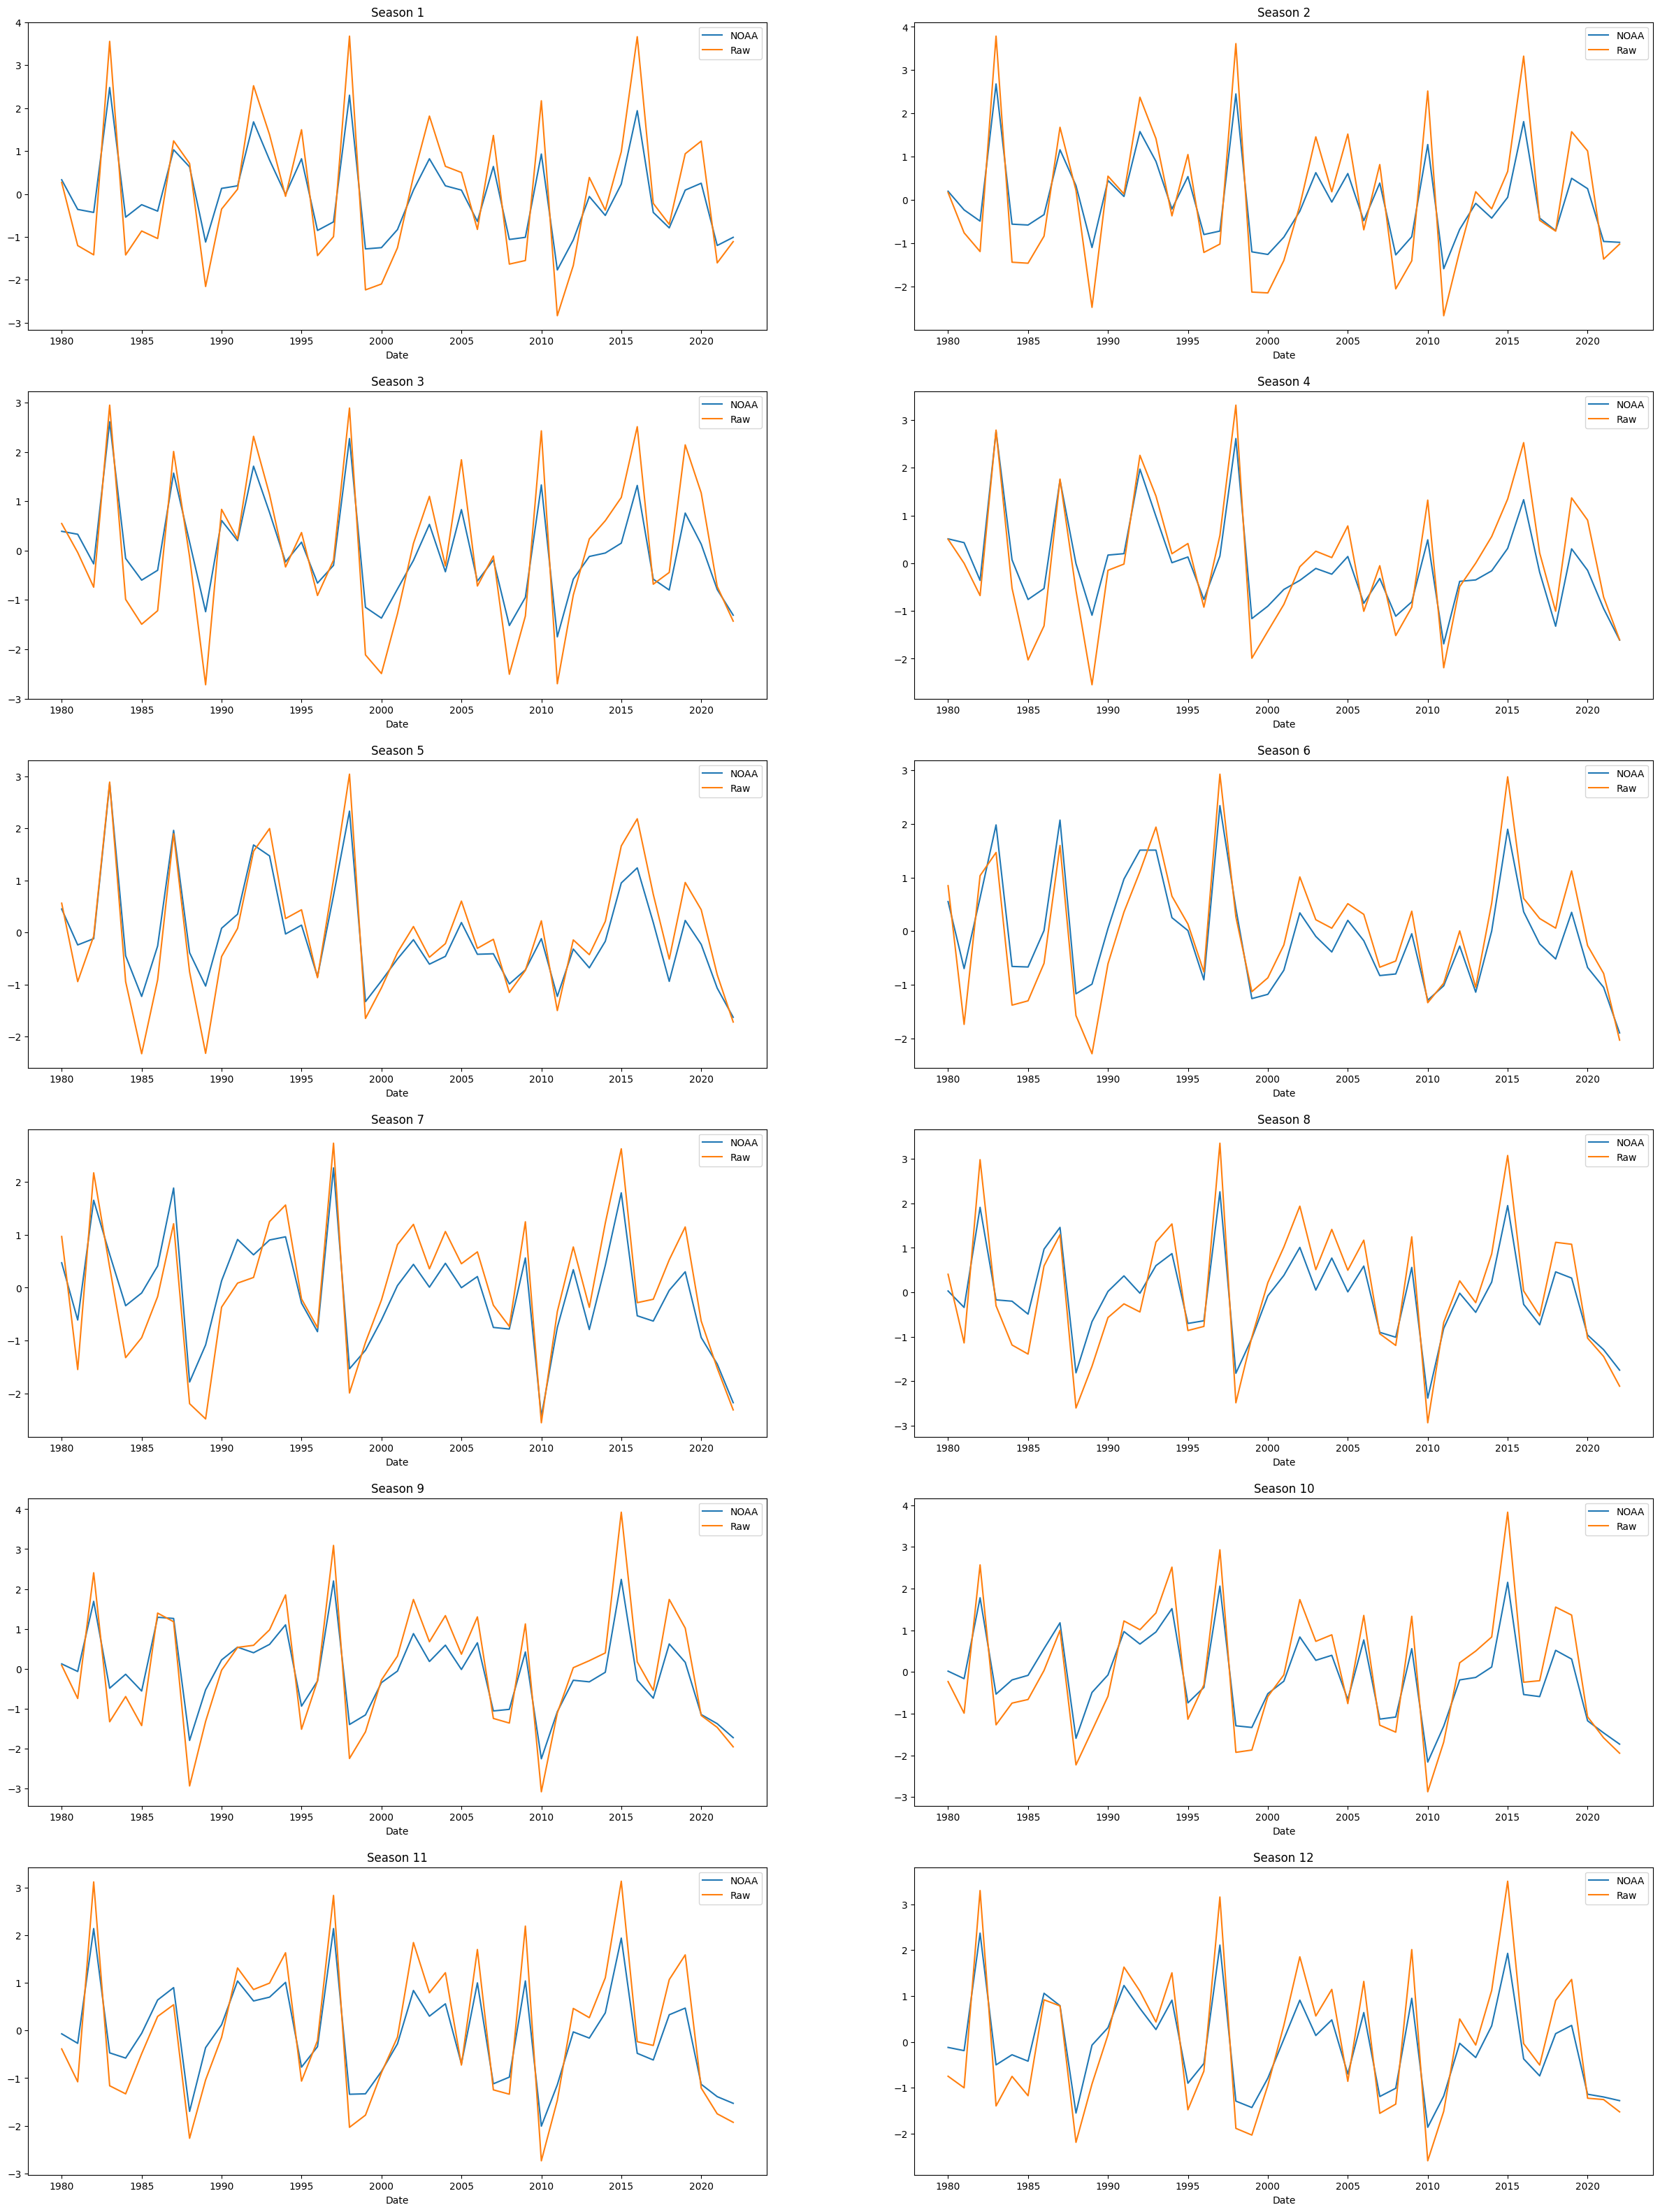

In [6]:
selected = df_mei[(df_mei["Year"]< 2023) & (df_mei["Year"] > 1979)]
selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))
selected.set_index('Date', inplace=True)

fig, axs = plt.subplots(6, 2, figsize=(30,40))
for i in range(1,13):
    axs.flatten()[i-1].plot(selected.index, selected[f"{i}"], label="NOAA")
    #if i>=3 and i not in [5,6]:
    #    pcs[i-1][1] = -pcs[i-1][1]
    axs.flatten()[i-1].plot(selected.index, pcs[i-1][1][0], label="Raw")
    axs.flatten()[i-1].set_title(f"Season {i}")
    axs.flatten()[i-1].set_xlabel("Date")
    axs.flatten()[i-1].legend()
plt.show()
        

We see that the reproduction for every biseason index is coherent with the one from NOAA. Note that we had to choose independently for each season the sign of the PC. This is an valid decision because the eigenvector/value. 

In [6]:
pd.options.mode.chained_assignment = None
for i in range(len(pcs)):
    selected[f"raw_{i+1}"] = pcs[i][1][0]

positions_to_highlight = [(i, i-12) for i in range(13,25)]  

def highlight_positions(data, positions):
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    
    for row, col in positions:
        styles.iloc[row, col] = 'background-color: red;'
    
    return styles

styled_corr_matrix = selected.corr().style.apply(highlight_positions, positions=positions_to_highlight, axis=None)

styled_corr_matrix

We can see high correlation in every reproduced index. The least correlated months correspond to the summer time, which previously got to 0.6 but improved by detrending (linearly) the data. This is a step not mentioned in any Mei/EOF reproduction (only on constant detrend, which is getting anomalies).

Lets form together the complete MEI.v2 Index:

In [7]:
selected = df_mei[(df_mei["Year"]< 2023) & (df_mei["Year"] > 1979)]
df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name='NOAA')
df_melted["Month"] = pd.to_numeric(df_melted["Month"])
df_melted = df_melted.sort_values(['Year','Month'])

df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
df_melted.set_index('Date', inplace=True)

df_melted.drop(columns=["Year", "Month"],inplace=True)

In [8]:
full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][0][i])

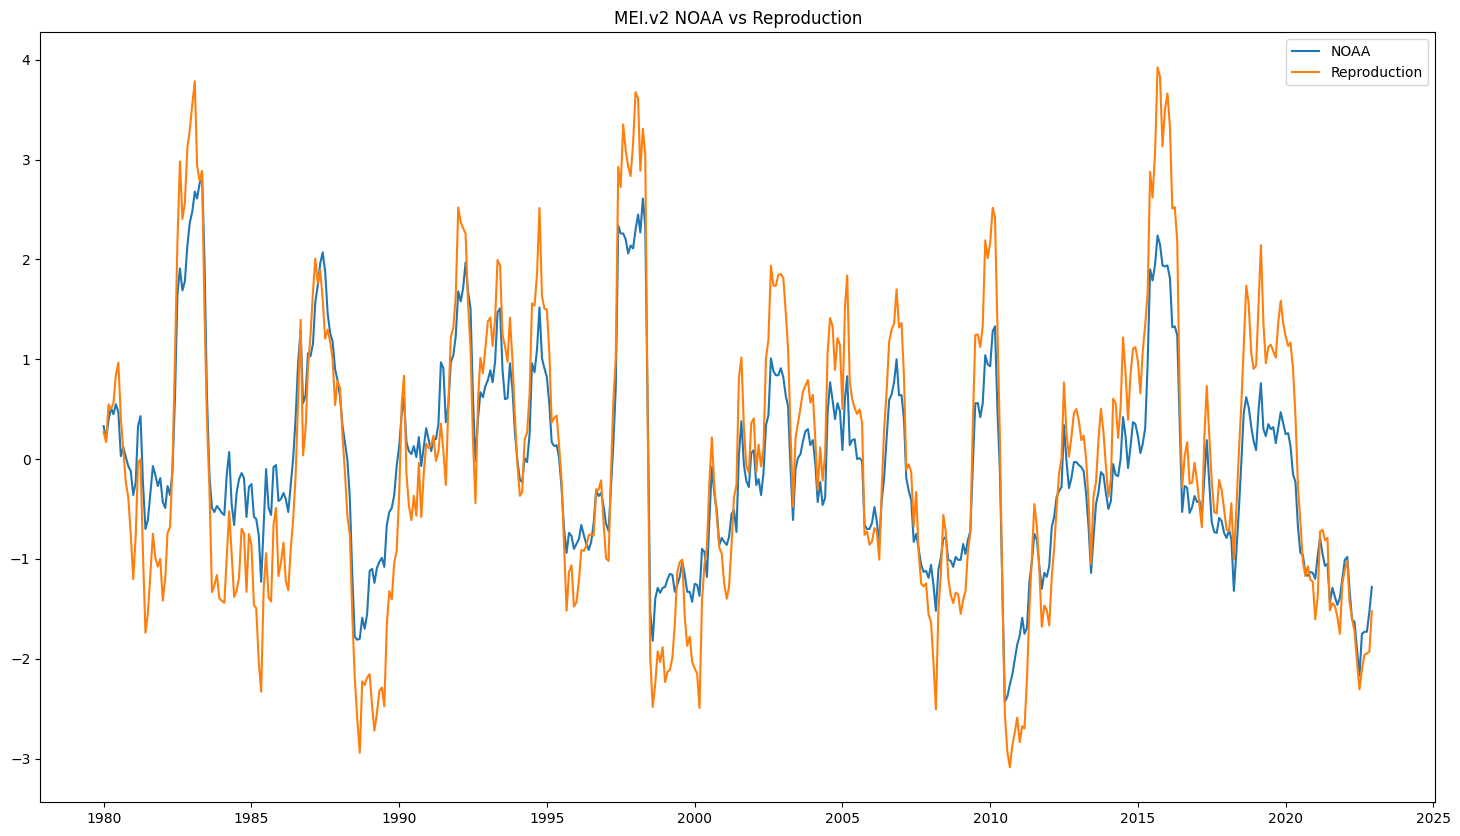

In [9]:
plt.figure(figsize=(18,10))
plt.plot(df_melted.index, df_melted["NOAA"], label="NOAA")
plt.plot(df_melted.index, full_mei, label="Reproduction")
plt.legend()
plt.title("MEI.v2 NOAA vs Reproduction")
plt.show()

We can see that the reproduction is nearly the same. Note: If we factor our reproduction by 0.7, the reproduction is practically the same.

## FFT of PC's

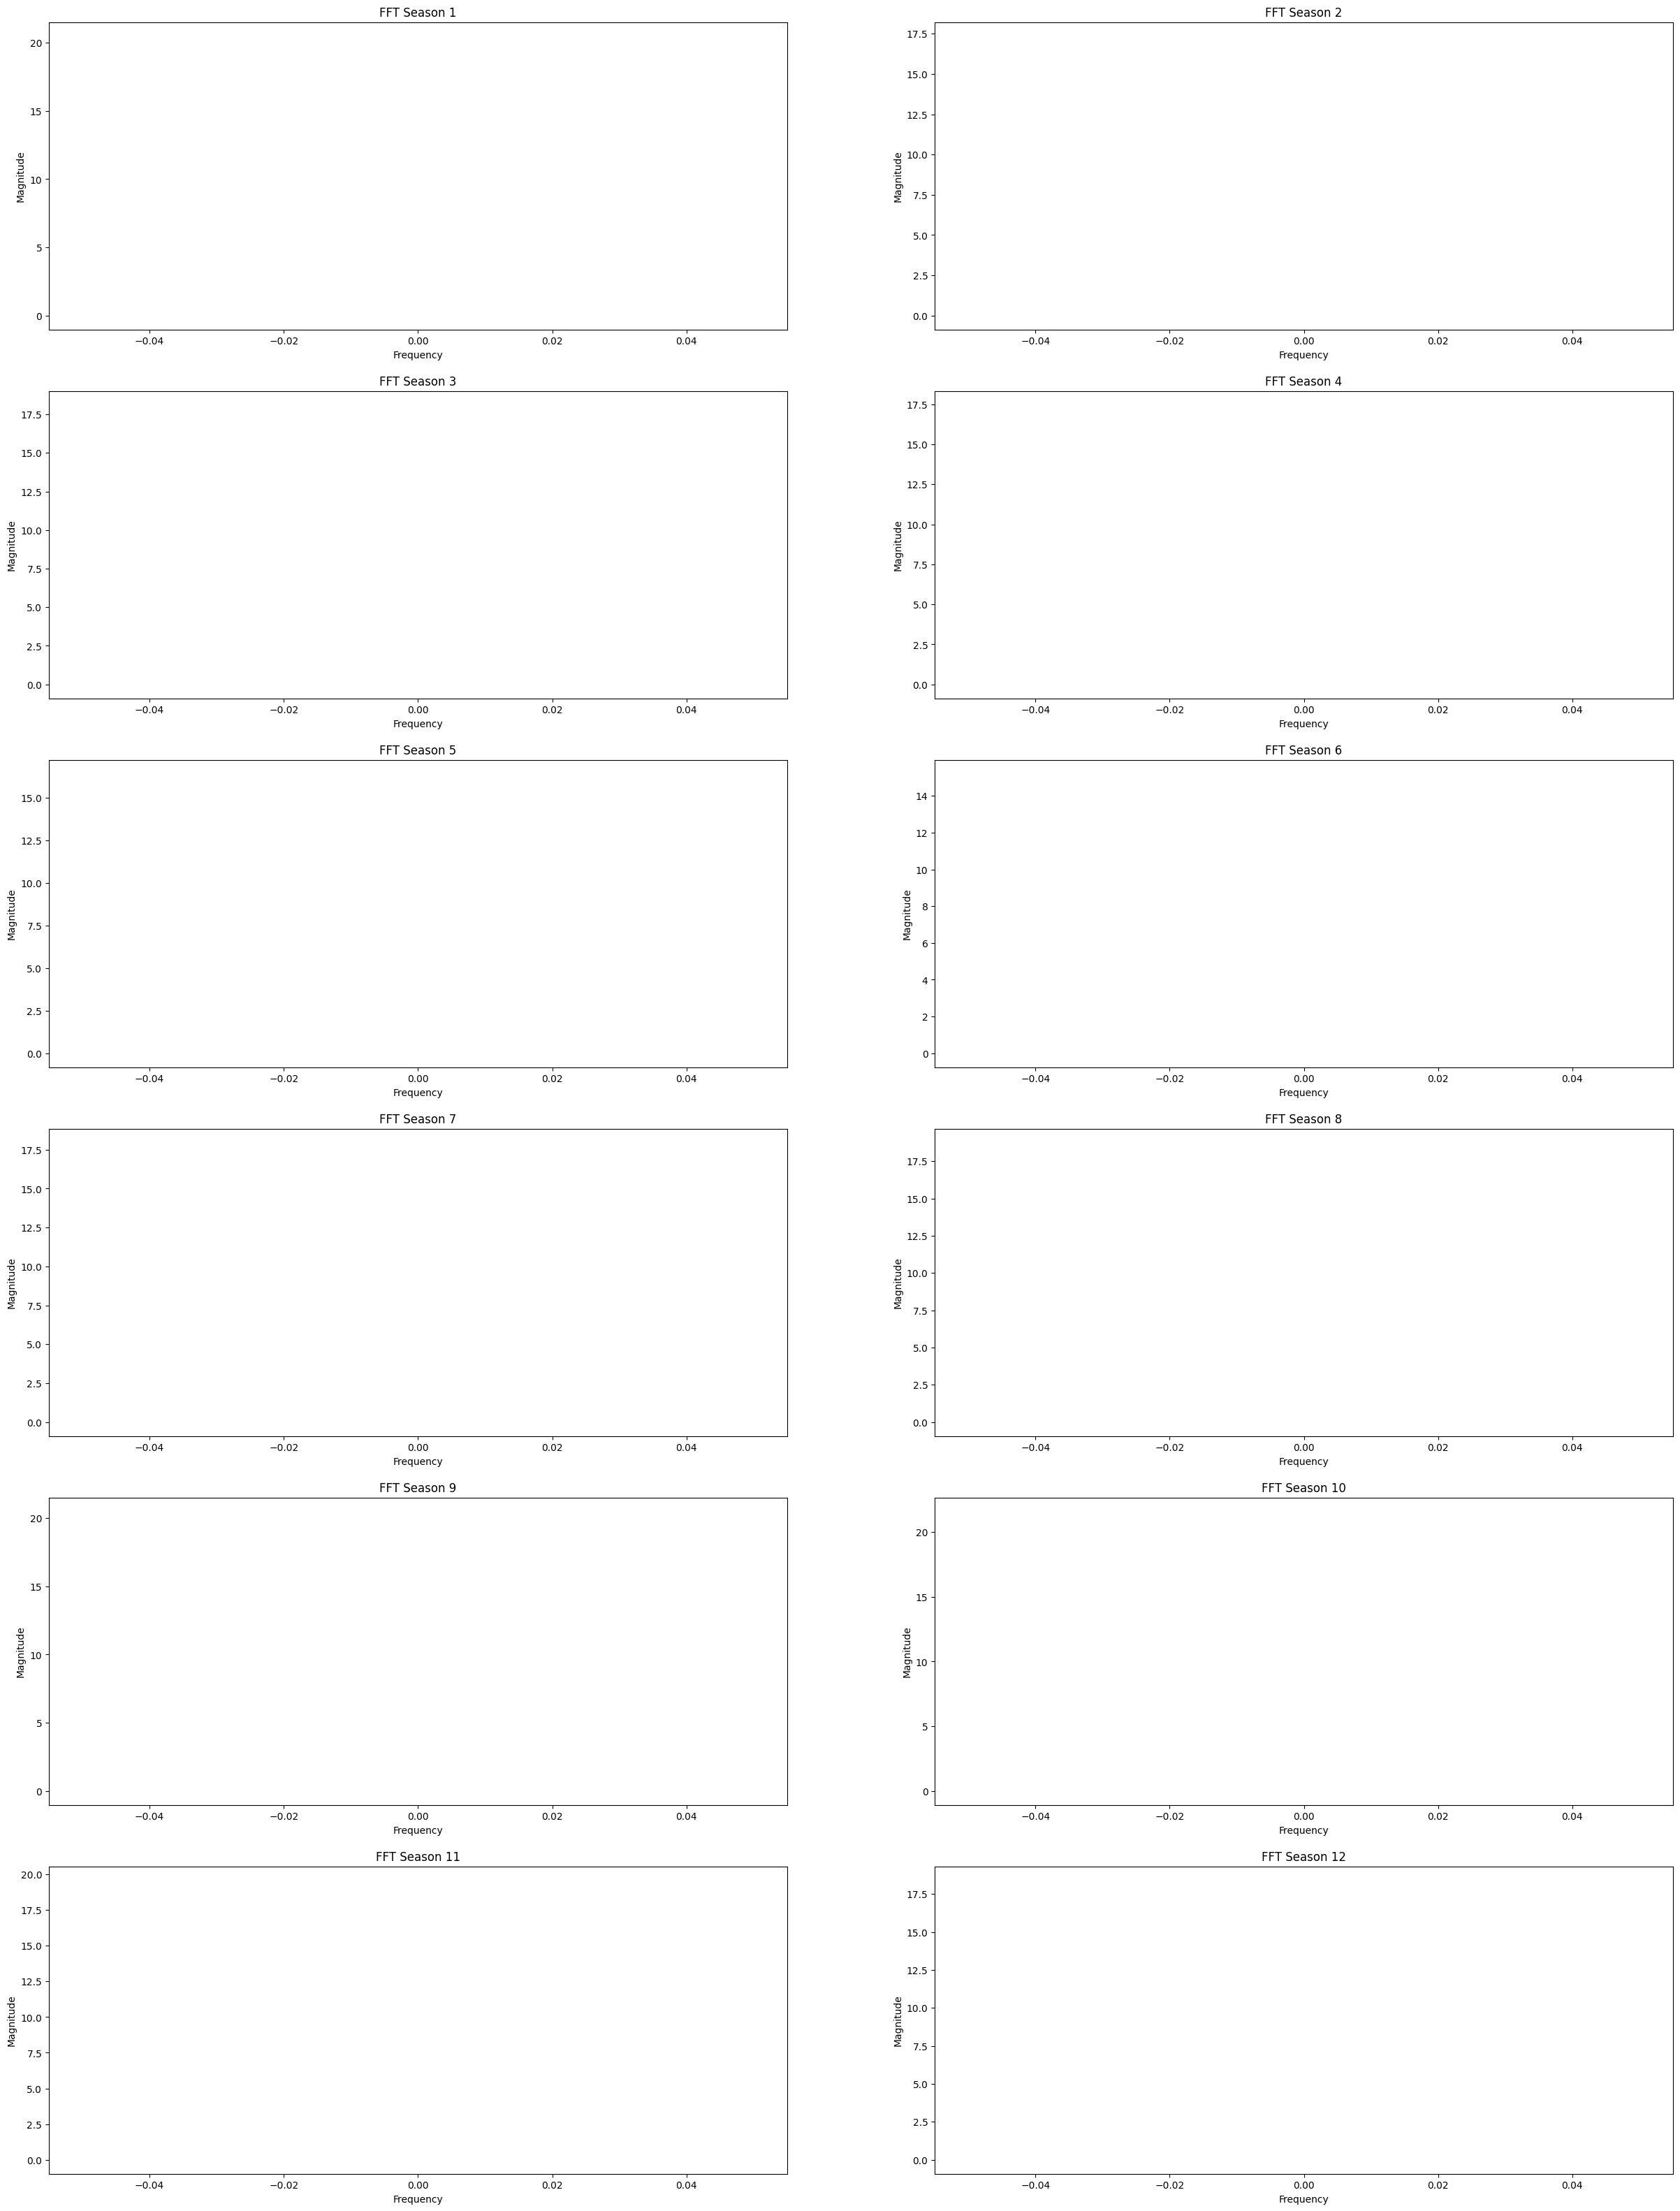

In [10]:
def compute_fft(pc, sampling_interval):
    fft_result = np.fft.fft(pc)    
    freqs = np.fft.fftfreq(len(pc), d=sampling_interval)
    magnitude = np.abs(fft_result)
    
    return freqs, magnitude

sampling_interval = 1/12 # 1/12=="yearly", 1=="monthly"

fig, axs = plt.subplots(6, 2, figsize=(30,40))
for i in range(1,13):
    freqs, magnitude = compute_fft(pcs[i-1][1], sampling_interval)

    axs.flatten()[i-1].plot(freqs[:len(freqs)//2], magnitude[:len(magnitude)//2])
    axs.flatten()[i-1].set_title(f"FFT Season {i}")
    axs.flatten()[i-1].set_xlabel("Frequency")
    axs.flatten()[i-1].set_ylabel("Magnitude")
plt.show()
        

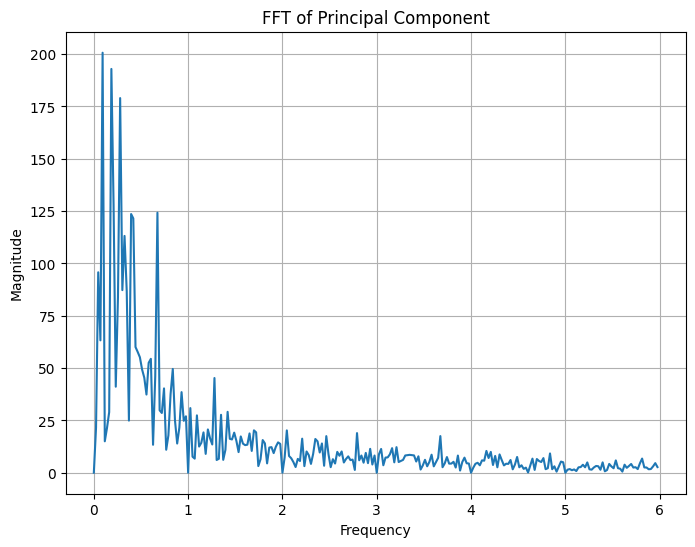

In [11]:
freqs, magnitudes = compute_fft(full_mei, 1/12)

# Plot the FFT result
plt.figure(figsize=(8, 6))
plt.plot(freqs[:len(freqs)//2], magnitudes[:len(magnitudes)//2])
plt.title('FFT of Principal Component')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [12]:
top_3_indices = np.argsort(magnitudes[:len(magnitudes)//2])[-4:]  
top_3_indices = top_3_indices[np.argsort(magnitudes[:len(magnitudes)//2][top_3_indices])[::-1]]

top_3_frequencies = freqs[top_3_indices]
top_3_magnitudes = magnitudes[:len(magnitudes)//2][top_3_indices]

for i in range(4):
    print(f"Peak {i+1}: Frequency = {top_3_frequencies[i]}, Wavelength (Years) = {1/top_3_frequencies[i]/12}, Magnitude = {top_3_magnitudes[i]}")


Peak 1: Frequency = 0.09302325581395349, Wavelength (Years) = 0.8958333333333334, Magnitude = 200.65493242477714
Peak 2: Frequency = 0.18604651162790697, Wavelength (Years) = 0.4479166666666667, Magnitude = 192.90609700319453
Peak 3: Frequency = 0.27906976744186046, Wavelength (Years) = 0.2986111111111111, Magnitude = 178.98373980206625
Peak 4: Frequency = 0.20930232558139533, Wavelength (Years) = 0.3981481481481482, Magnitude = 128.1158715255436


## Modes first PC

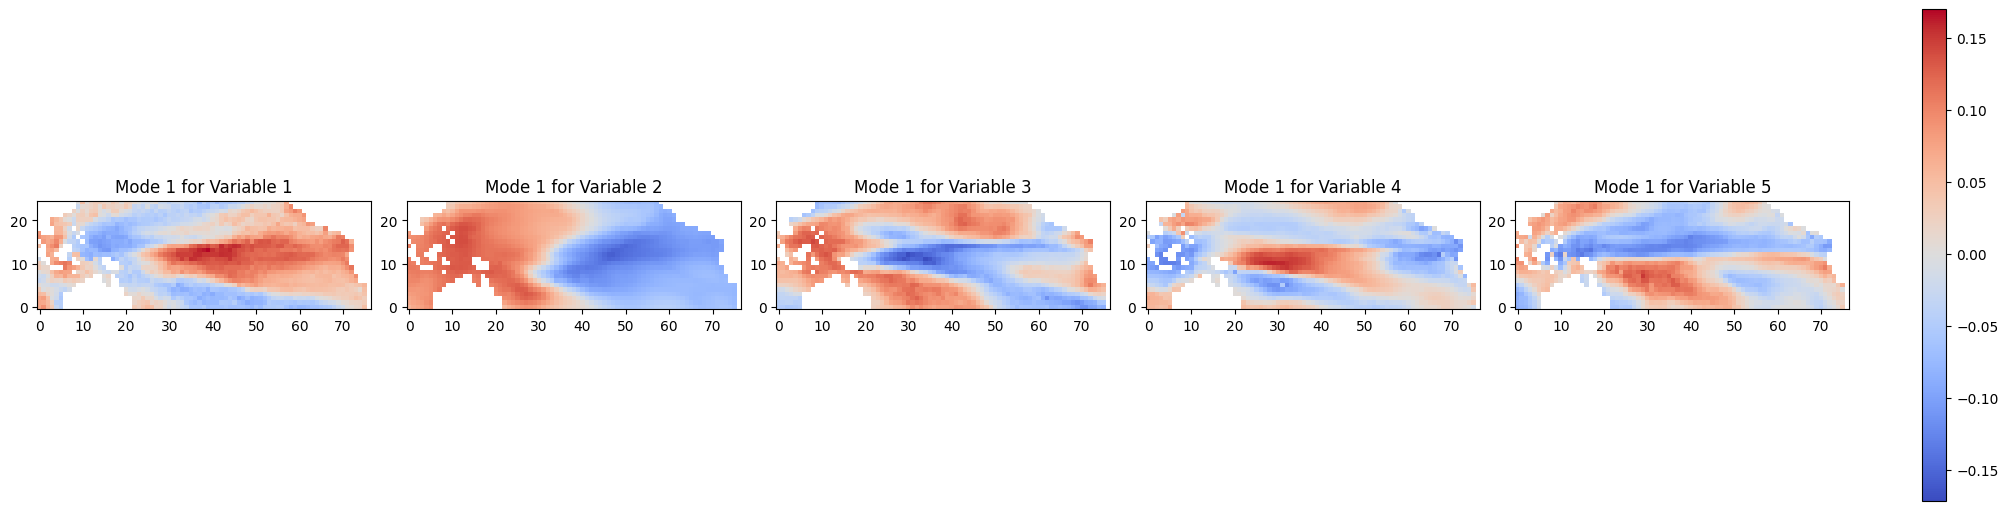

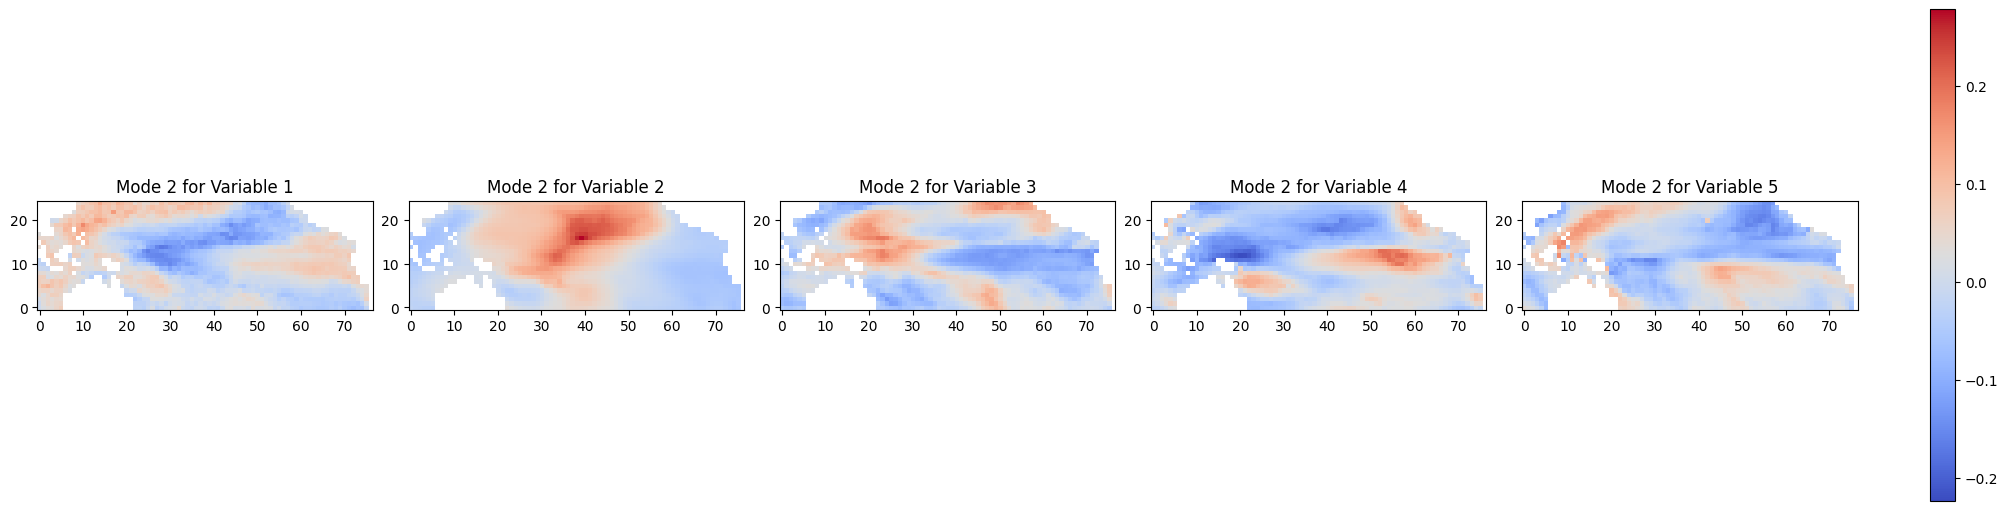

In [13]:
def map_modes_to_full_grid(modes, valid_columns, grid_shape, n_variables):
    lat, lon = grid_shape
    mode_length_per_variable = lat * lon
    
    full_modes = []
    for mode in modes:
        full_mode = np.full((mode_length_per_variable * n_variables,), np.nan)  
        full_mode[valid_columns] = mode  
        full_modes.append(full_mode)
    
    return full_modes

def plot_variable_modes_shared(modes, grid_shape, n_variables, k):
    lat, lon = grid_shape
    mode_length_per_variable = lat * lon
    
    for i in range(k):
        fig, axes = plt.subplots(1, n_variables, figsize=(20, 5), constrained_layout=True)
        
        reshaped_modes = []
        for j in range(n_variables):
            variable_mode = modes[i][j * mode_length_per_variable : (j + 1) * mode_length_per_variable]
            reshaped_mode = variable_mode.reshape(grid_shape)
            reshaped_modes.append(reshaped_mode)
        
        vmin = np.nanmin(reshaped_modes)
        vmax = np.nanmax(reshaped_modes)
        
        im_list = []
        for j, ax in enumerate(axes):
            im = ax.imshow(reshaped_modes[j], cmap='coolwarm', origin='lower', vmin=vmin, vmax=vmax)
            ax.set_title(f"Mode {i+1} for Variable {j+1}")
            im_list.append(im)
        
        # Create a single colorbar for all subplots
        cbar = fig.colorbar(im_list[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        
        plt.show()

full_modes = map_modes_to_full_grid(pcs[0][-2], pcs[0][-1], (25,77), n_variables=5)
plot_variable_modes_shared(full_modes, (25,77), 5, 2)

Now that we plot the 5 plots using the same colorbar, we can see that the magnitudes between them is fairly the same, i.e. the contribution in spatial variability to the principal component is in the same magnitude from each variable. 

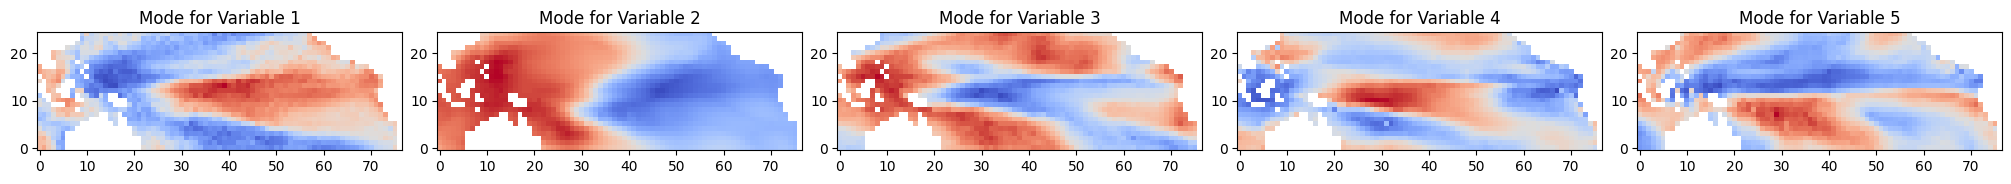

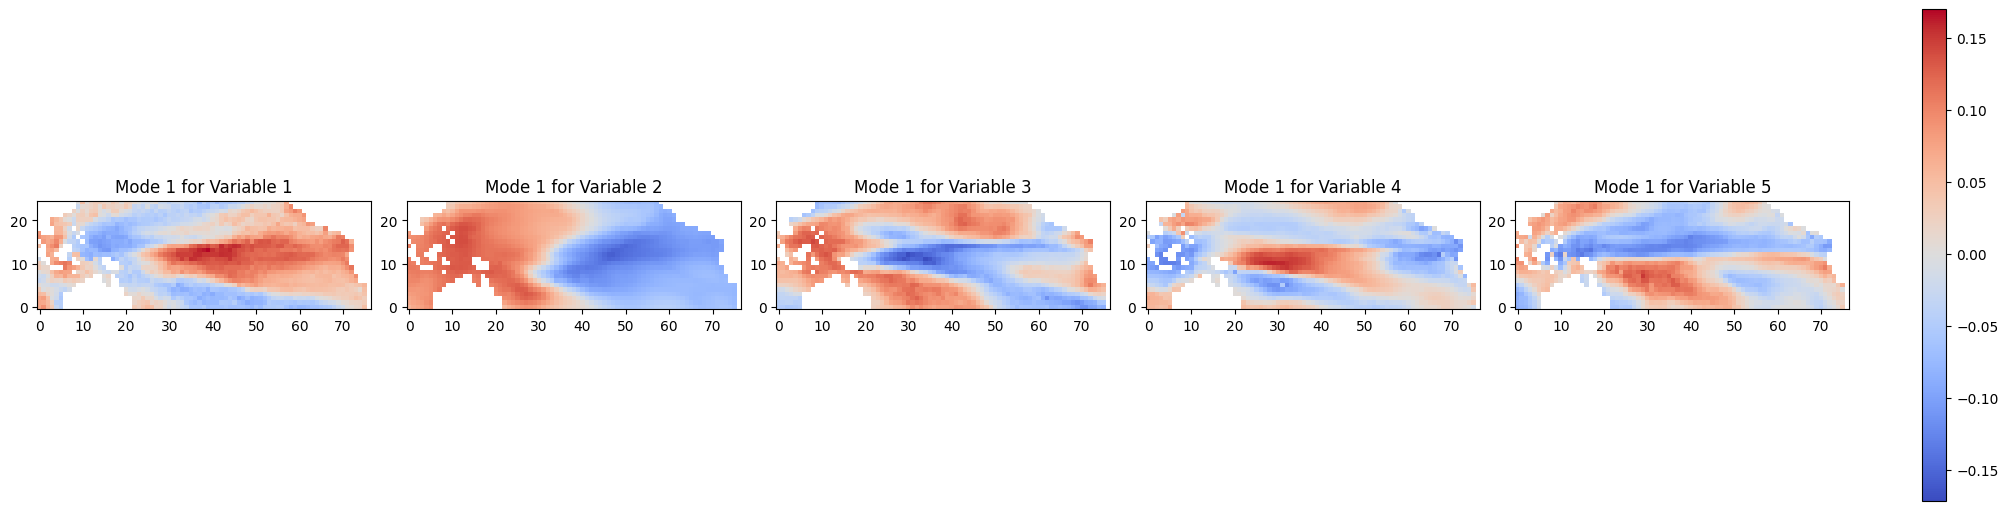

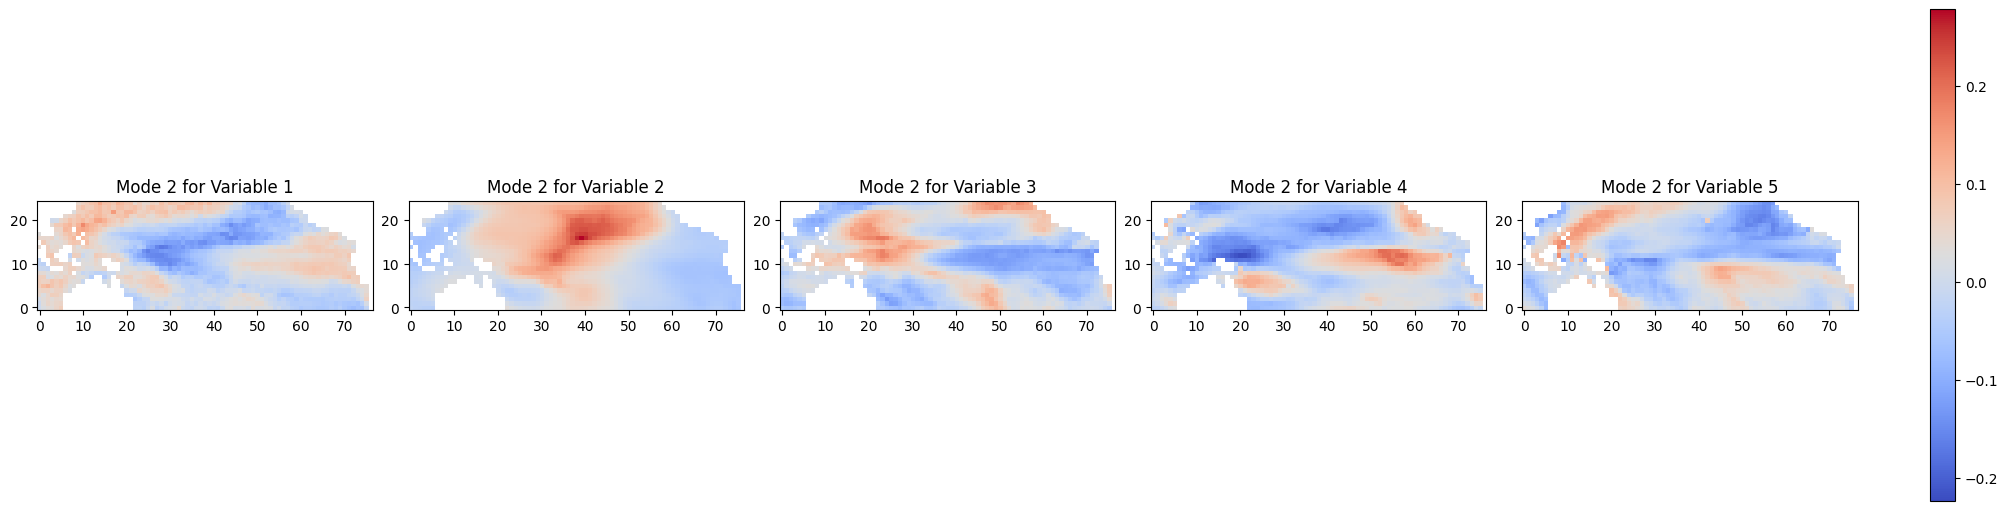

In [14]:
def plot_variable_modes(mode, grid_shape, n_variables):
    lat, lon = grid_shape
    mode_length_per_variable = lat * lon
    fig, axes = plt.subplots(1, n_variables, figsize=(20, 5), constrained_layout=True)

    for i in range(n_variables):
        variable_mode = mode[i * mode_length_per_variable : (i + 1) * mode_length_per_variable]
        reshaped_mode = variable_mode.reshape(grid_shape)
        
        axes[i].imshow(reshaped_mode, cmap='coolwarm', origin='lower')
        axes[i].set_title(f"Mode for Variable {i+1}")
    plt.show()

plot_variable_modes(full_modes[0], (25,77), n_variables=5)
plot_variable_modes_shared(full_modes, (25,77), 5, 2)

- Check the magnitudes of each mode for each variable to compare between them the contribution to the variability of the Index
- Check n-th components and their explained variability
- Explore different box, first separar en Norte y Sur o este y Oeste

## k-th Components

In [22]:
nmodes= 6
pcs = []
for i in range(1,13):
    pcs.append(get_first_pc(ds_5means, [1980, 2022], biseason=i, nmodes=nmodes))
    print("Eigenvalues for biseason", i, ":", np.round(pcs[i-1][0],3))
    print("Explained Variance for biseason", i , ":",np.round(pcs[i-1][2],4))
    print()

Eigenvalues for biseason 1 : [113.535  40.908  25.693  21.827  18.6    12.451]
Explained Variance for biseason 1 : [0.2922 0.1053 0.0661 0.0562 0.0479 0.032 ]

Eigenvalues for biseason 2 : [111.882  47.344  28.245  19.649  15.718  12.881]
Explained Variance for biseason 2 : [0.2857 0.1209 0.0721 0.0502 0.0401 0.0329]

Eigenvalues for biseason 3 : [99.212 55.783 27.446 22.666 16.505 15.133]
Explained Variance for biseason 3 : [0.2522 0.1418 0.0698 0.0576 0.042  0.0385]

Eigenvalues for biseason 4 : [77.614 56.668 23.141 22.522 16.944 15.069]
Explained Variance for biseason 4 : [0.2075 0.1515 0.0619 0.0602 0.0453 0.0403]

Eigenvalues for biseason 5 : [66.427 47.439 26.552 22.219 19.884 16.482]
Explained Variance for biseason 5 : [0.1792 0.1279 0.0716 0.0599 0.0536 0.0445]

Eigenvalues for biseason 6 : [59.702 44.083 26.416 25.358 21.123 19.237]
Explained Variance for biseason 6 : [0.1574 0.1162 0.0696 0.0668 0.0557 0.0507]

Eigenvalues for biseason 7 : [72.187 44.116 31.016 23.477 22.904

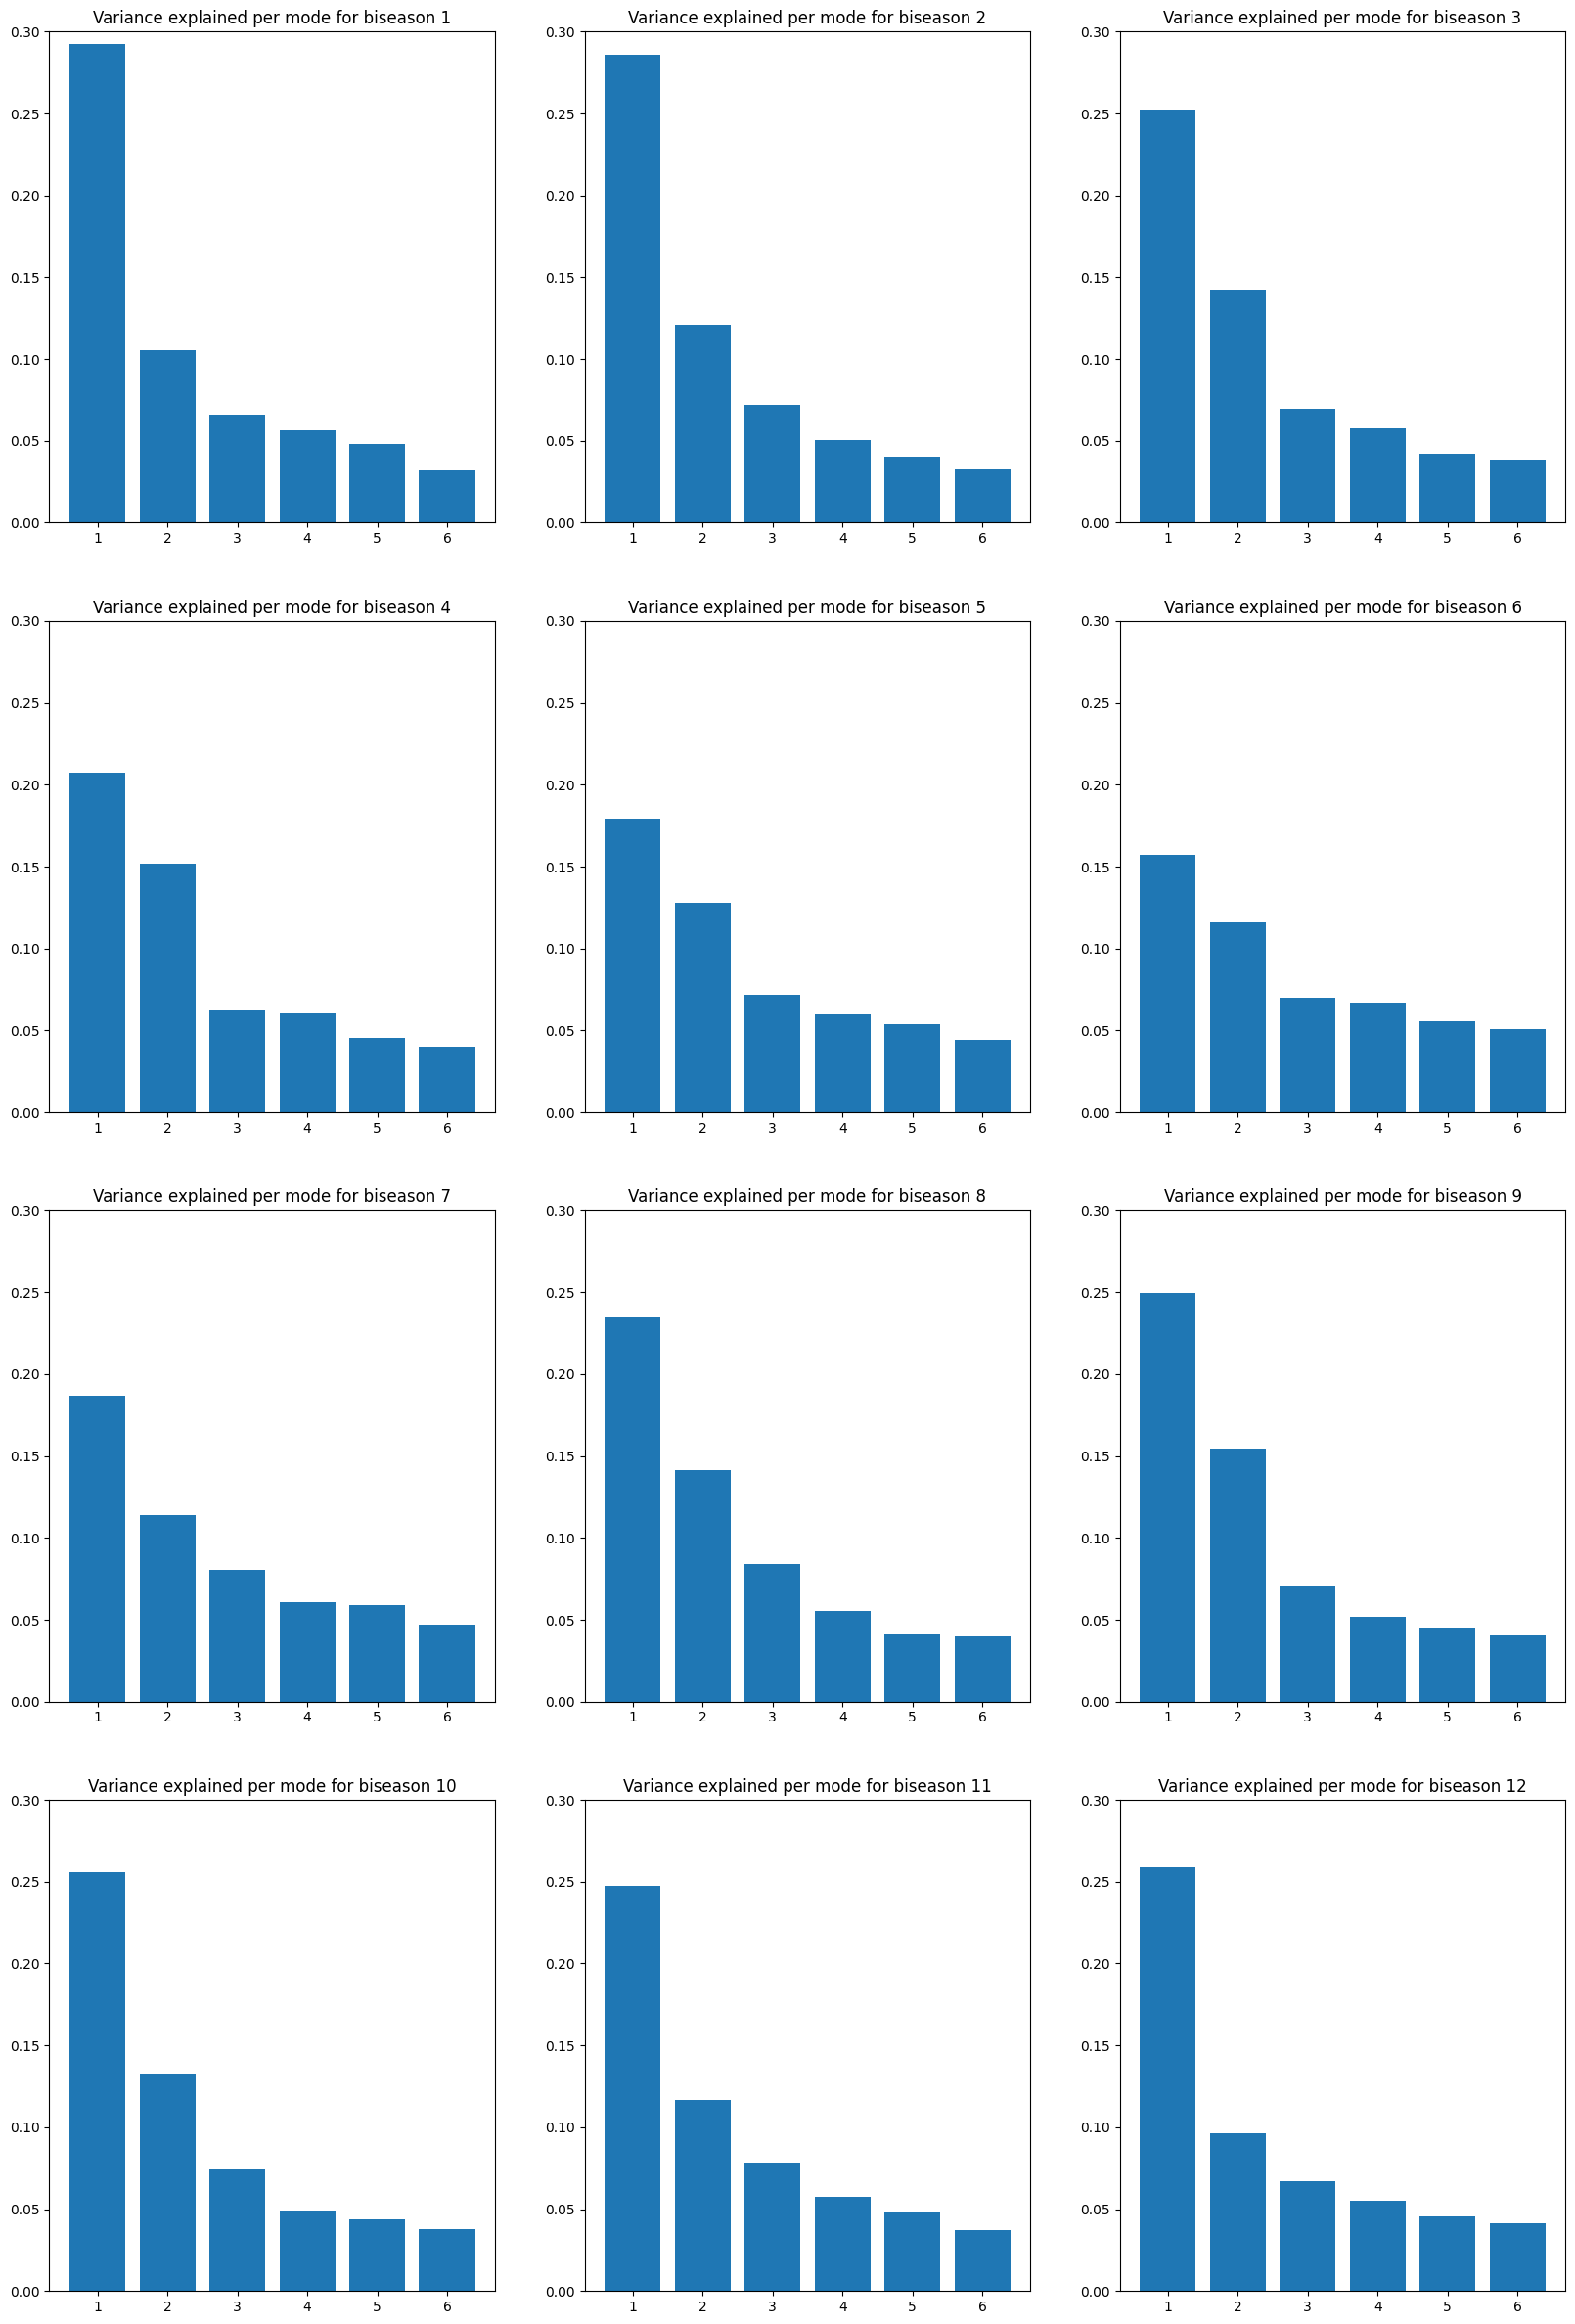

In [16]:
fig, axs = plt.subplots(4, 3, figsize=(20,30))
for i in range(12):
    axs.flatten()[i].bar(np.linspace(1,6,6), pcs[i][2])
    axs.flatten()[i].set_ylim([0,0.3])
    axs.flatten()[i].set_title(f"Variance explained per mode for biseason {i+1}")

### Check on 2nd PC

In [25]:
for i in range(len(pcs)):
    if pcs[i][1][0][3] < -2 or pcs[i][1][0][2] <-2: ##Correct first PC
        pcs[i][1][0] = -pcs[i][1][0]
        pcs[i][3][0] = -pcs[i][3][0]

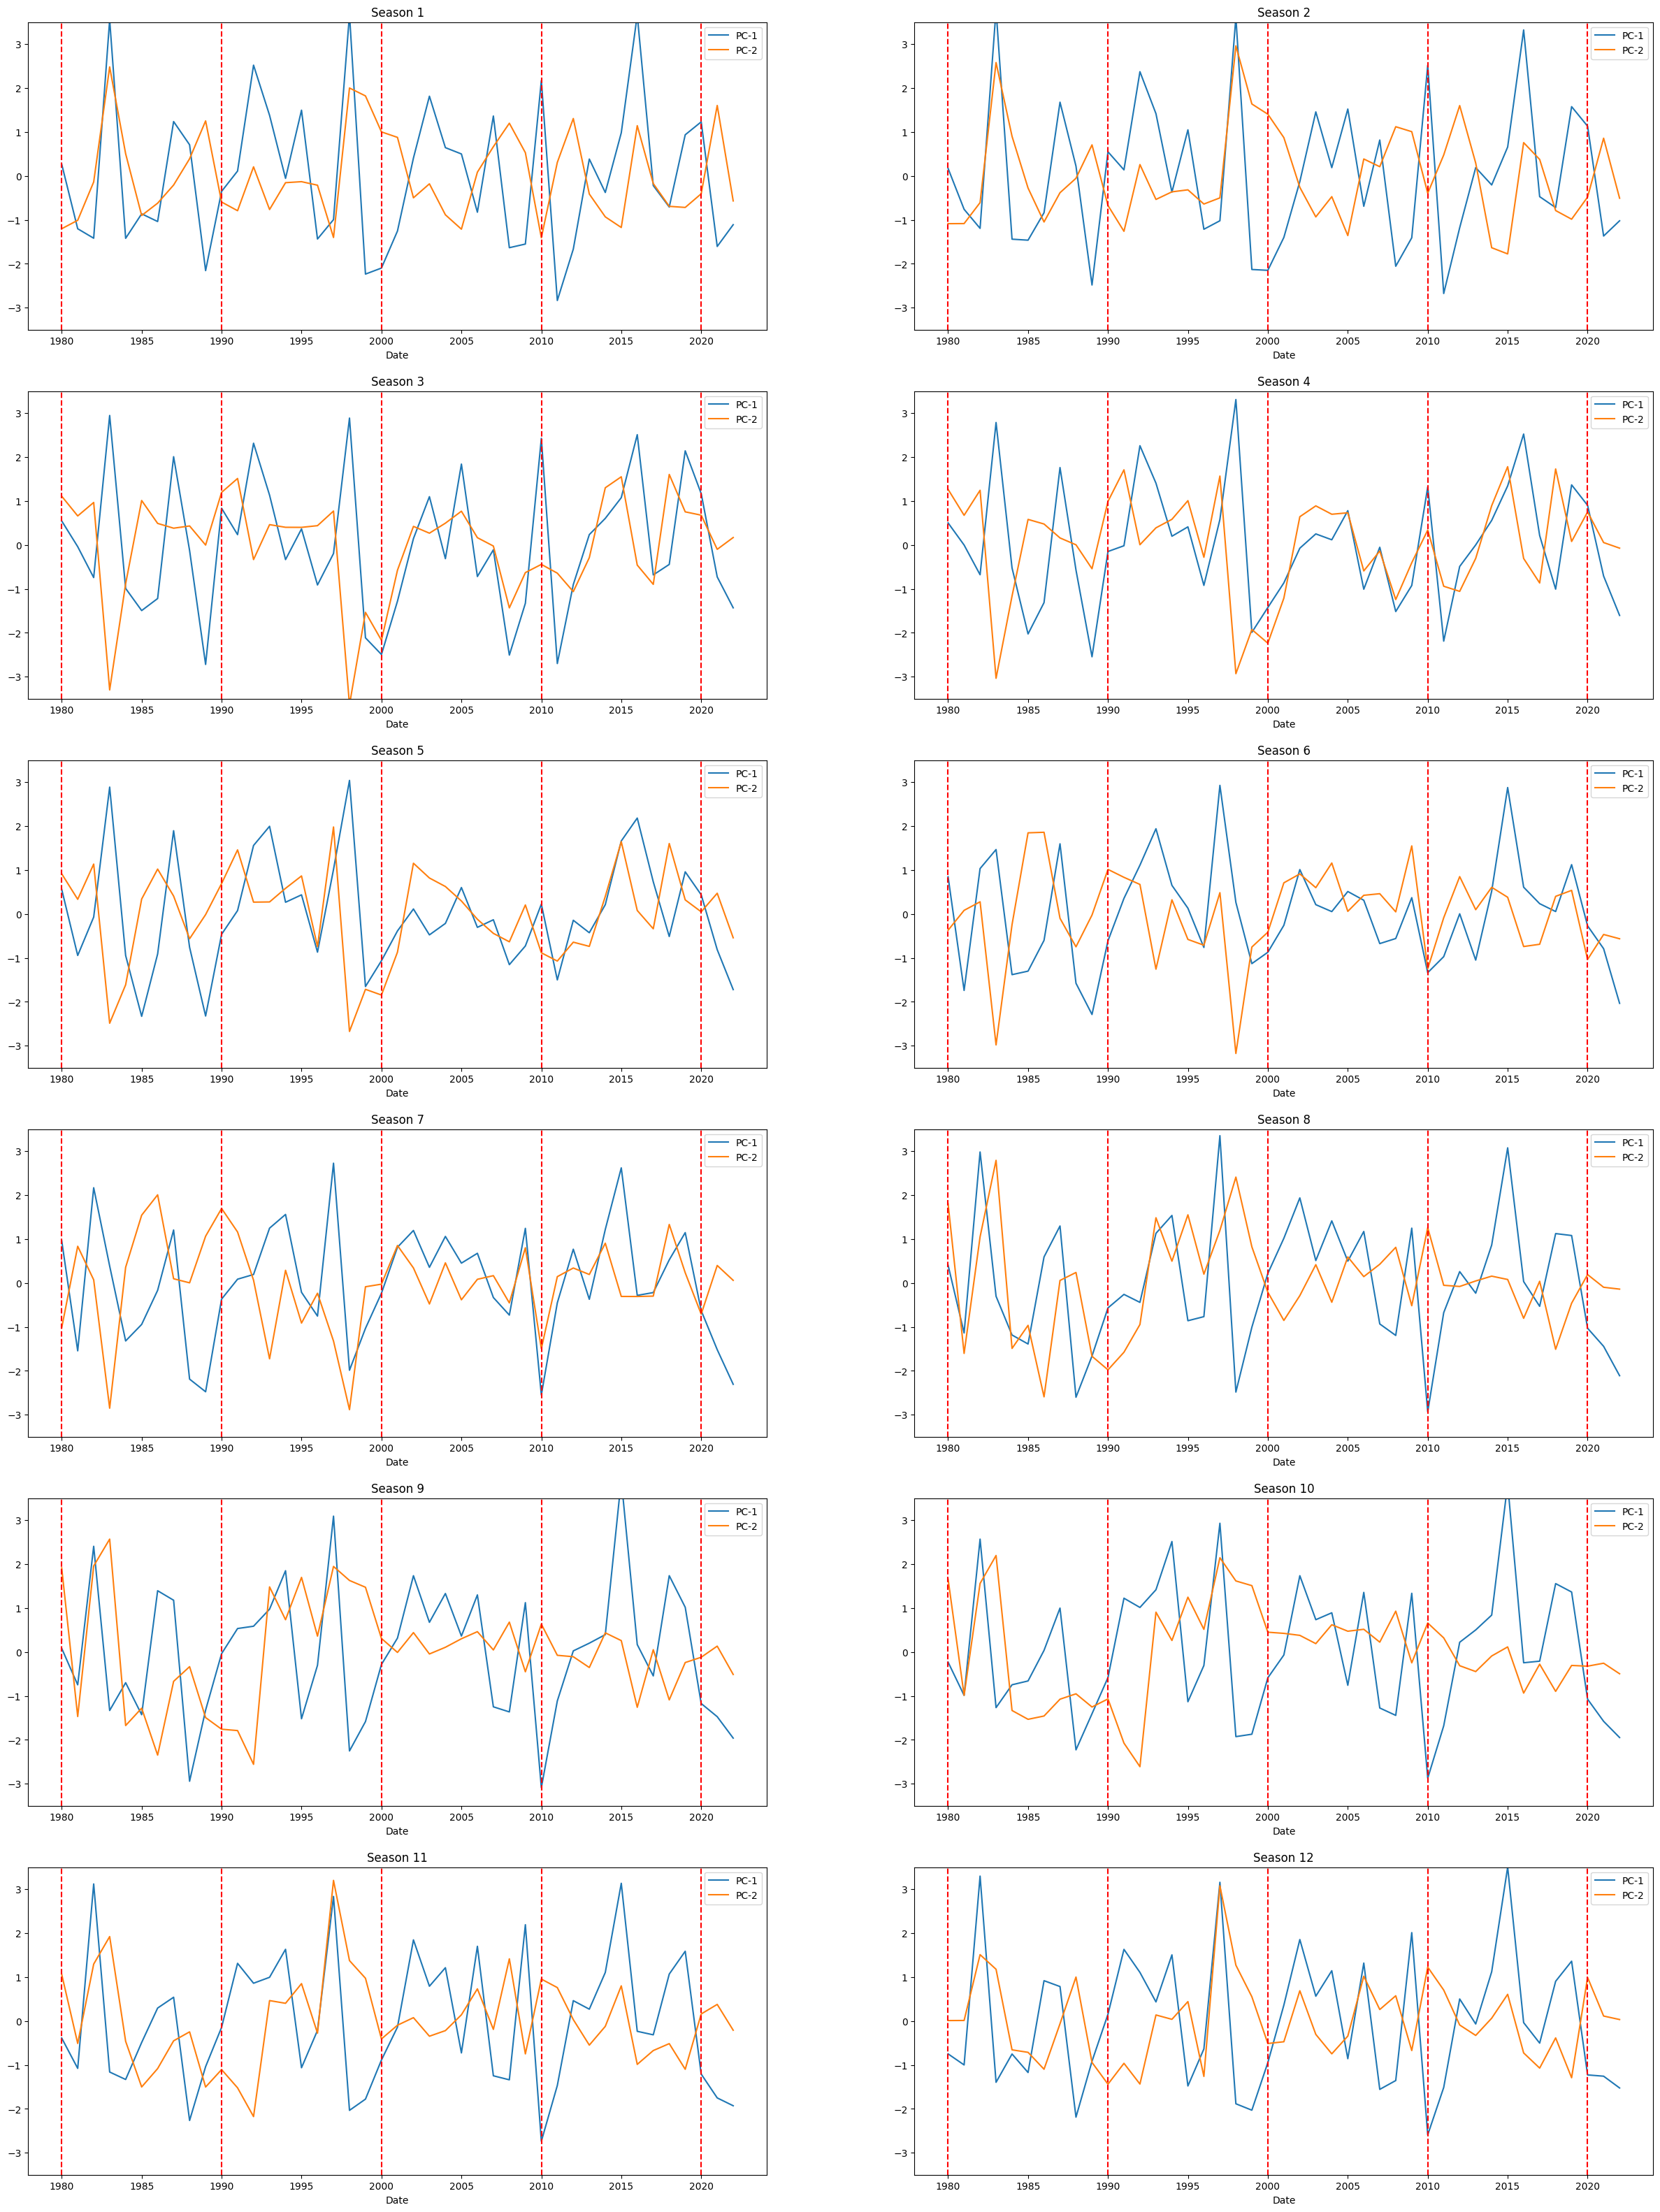

In [26]:
selected['Date'] = pd.to_datetime(selected[['Year']].assign(DAY=1, MONTH=1))
selected.set_index('Date', inplace=True)

fig, axs = plt.subplots(6, 2, figsize=(30,40))
for i in range(1,13):
    axs.flatten()[i-1].plot(selected.index, pcs[i-1][1][0], label="PC-1")
    axs.flatten()[i-1].plot(selected.index, pcs[i-1][1][1], label="PC-2")

    axs.flatten()[i-1].set_title(f"Season {i}")
    axs.flatten()[i-1].set_xlabel("Date")
    axs.flatten()[i-1].legend()
    axs.flatten()[i-1].set_ylim([-3.5, 3.5])
    for k in range(5):
        axs.flatten()[i-1].axvline(datetime.datetime(1980 +10*k, 1, 1), color="r", linestyle="--")

plt.show()
        

First PC is corrected. Should we correct second? If yes, should the peaks coincide with the first PC or total opposite cause orthogonality?

# Explore different boxes

## N-S

In [32]:
ds_5means = xr.load_dataset("5means.nc")
col_labels = ["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
df_mei = pd.read_csv("meiv2.data",sep="     |    ", header=None, engine="python", names=col_labels)

In [33]:
north_ds = ds_5means.sel(latitude=slice(0,30))
south_ds = ds_5means.sel(latitude=slice(-30,0))

In [34]:
north_pcs = []
for i in range(1,13):
    north_pcs.append(get_first_pc(north_ds, [1980, 2022], biseason=i, nmodes=1))
    print("First eigenvalue for biseason", i, ":", north_pcs[i-1][0], "   Explained Variance:", north_pcs[i-1][2])

for i in range(len(north_pcs)):
    if north_pcs[i][1][0][3] < -1.5 or north_pcs[i][1][0][2] <-1.5: ##Correct first PC
        north_pcs[i][1][0] = -north_pcs[i][1][0]
        north_pcs[i][3][0] = -north_pcs[i][3][0]

First eigenvalue for biseason 1 : [60.20785718]    Explained Variance: [0.29881195]
First eigenvalue for biseason 2 : [62.28958553]    Explained Variance: [0.2998678]
First eigenvalue for biseason 3 : [55.43824289]    Explained Variance: [0.26966909]
First eigenvalue for biseason 4 : [45.24817402]    Explained Variance: [0.23045252]
First eigenvalue for biseason 5 : [38.62043439]    Explained Variance: [0.20627588]
First eigenvalue for biseason 6 : [33.80881255]    Explained Variance: [0.17665434]
First eigenvalue for biseason 7 : [40.34663173]    Explained Variance: [0.20543139]
First eigenvalue for biseason 8 : [49.04342852]    Explained Variance: [0.25328367]
First eigenvalue for biseason 9 : [51.22855001]    Explained Variance: [0.26432182]
First eigenvalue for biseason 10 : [47.76872071]    Explained Variance: [0.25111604]
First eigenvalue for biseason 11 : [46.27133566]    Explained Variance: [0.24162864]
First eigenvalue for biseason 12 : [51.68603929]    Explained Variance: [0.

In [35]:
south_pcs = []
for i in range(1,13):
    south_pcs.append(get_first_pc(south_ds, [1980, 2022], biseason=i, nmodes=1))
    print("First eigenvalue for biseason", i, ":", south_pcs[i-1][0], "   Explained Variance:", south_pcs[i-1][2])

for i in range(len(north_pcs)):
    if south_pcs[i][1][0][3] < -1.5 or south_pcs[i][1][0][2] <-1.5: ##Correct first PC
        south_pcs[i][1][0] = -south_pcs[i][1][0]
        south_pcs[i][3][0] = -south_pcs[i][3][0]

First eigenvalue for biseason 1 : [63.99691362]    Explained Variance: [0.31283339]
First eigenvalue for biseason 2 : [59.86454122]    Explained Variance: [0.29799223]
First eigenvalue for biseason 3 : [52.87641408]    Explained Variance: [0.25906194]
First eigenvalue for biseason 4 : [41.5379325]    Explained Variance: [0.21572433]
First eigenvalue for biseason 5 : [37.19919273]    Explained Variance: [0.18783305]
First eigenvalue for biseason 6 : [35.16634689]    Explained Variance: [0.17337707]
First eigenvalue for biseason 7 : [41.69471728]    Explained Variance: [0.20311403]
First eigenvalue for biseason 8 : [54.45023892]    Explained Variance: [0.2570553]
First eigenvalue for biseason 9 : [59.46000538]    Explained Variance: [0.27085884]
First eigenvalue for biseason 10 : [59.23257729]    Explained Variance: [0.28424702]
First eigenvalue for biseason 11 : [57.06908947]    Explained Variance: [0.27670211]
First eigenvalue for biseason 12 : [57.18994624]    Explained Variance: [0.2

C:\Users\marti\AppData\Local\Temp\ipykernel_10432\251920856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))


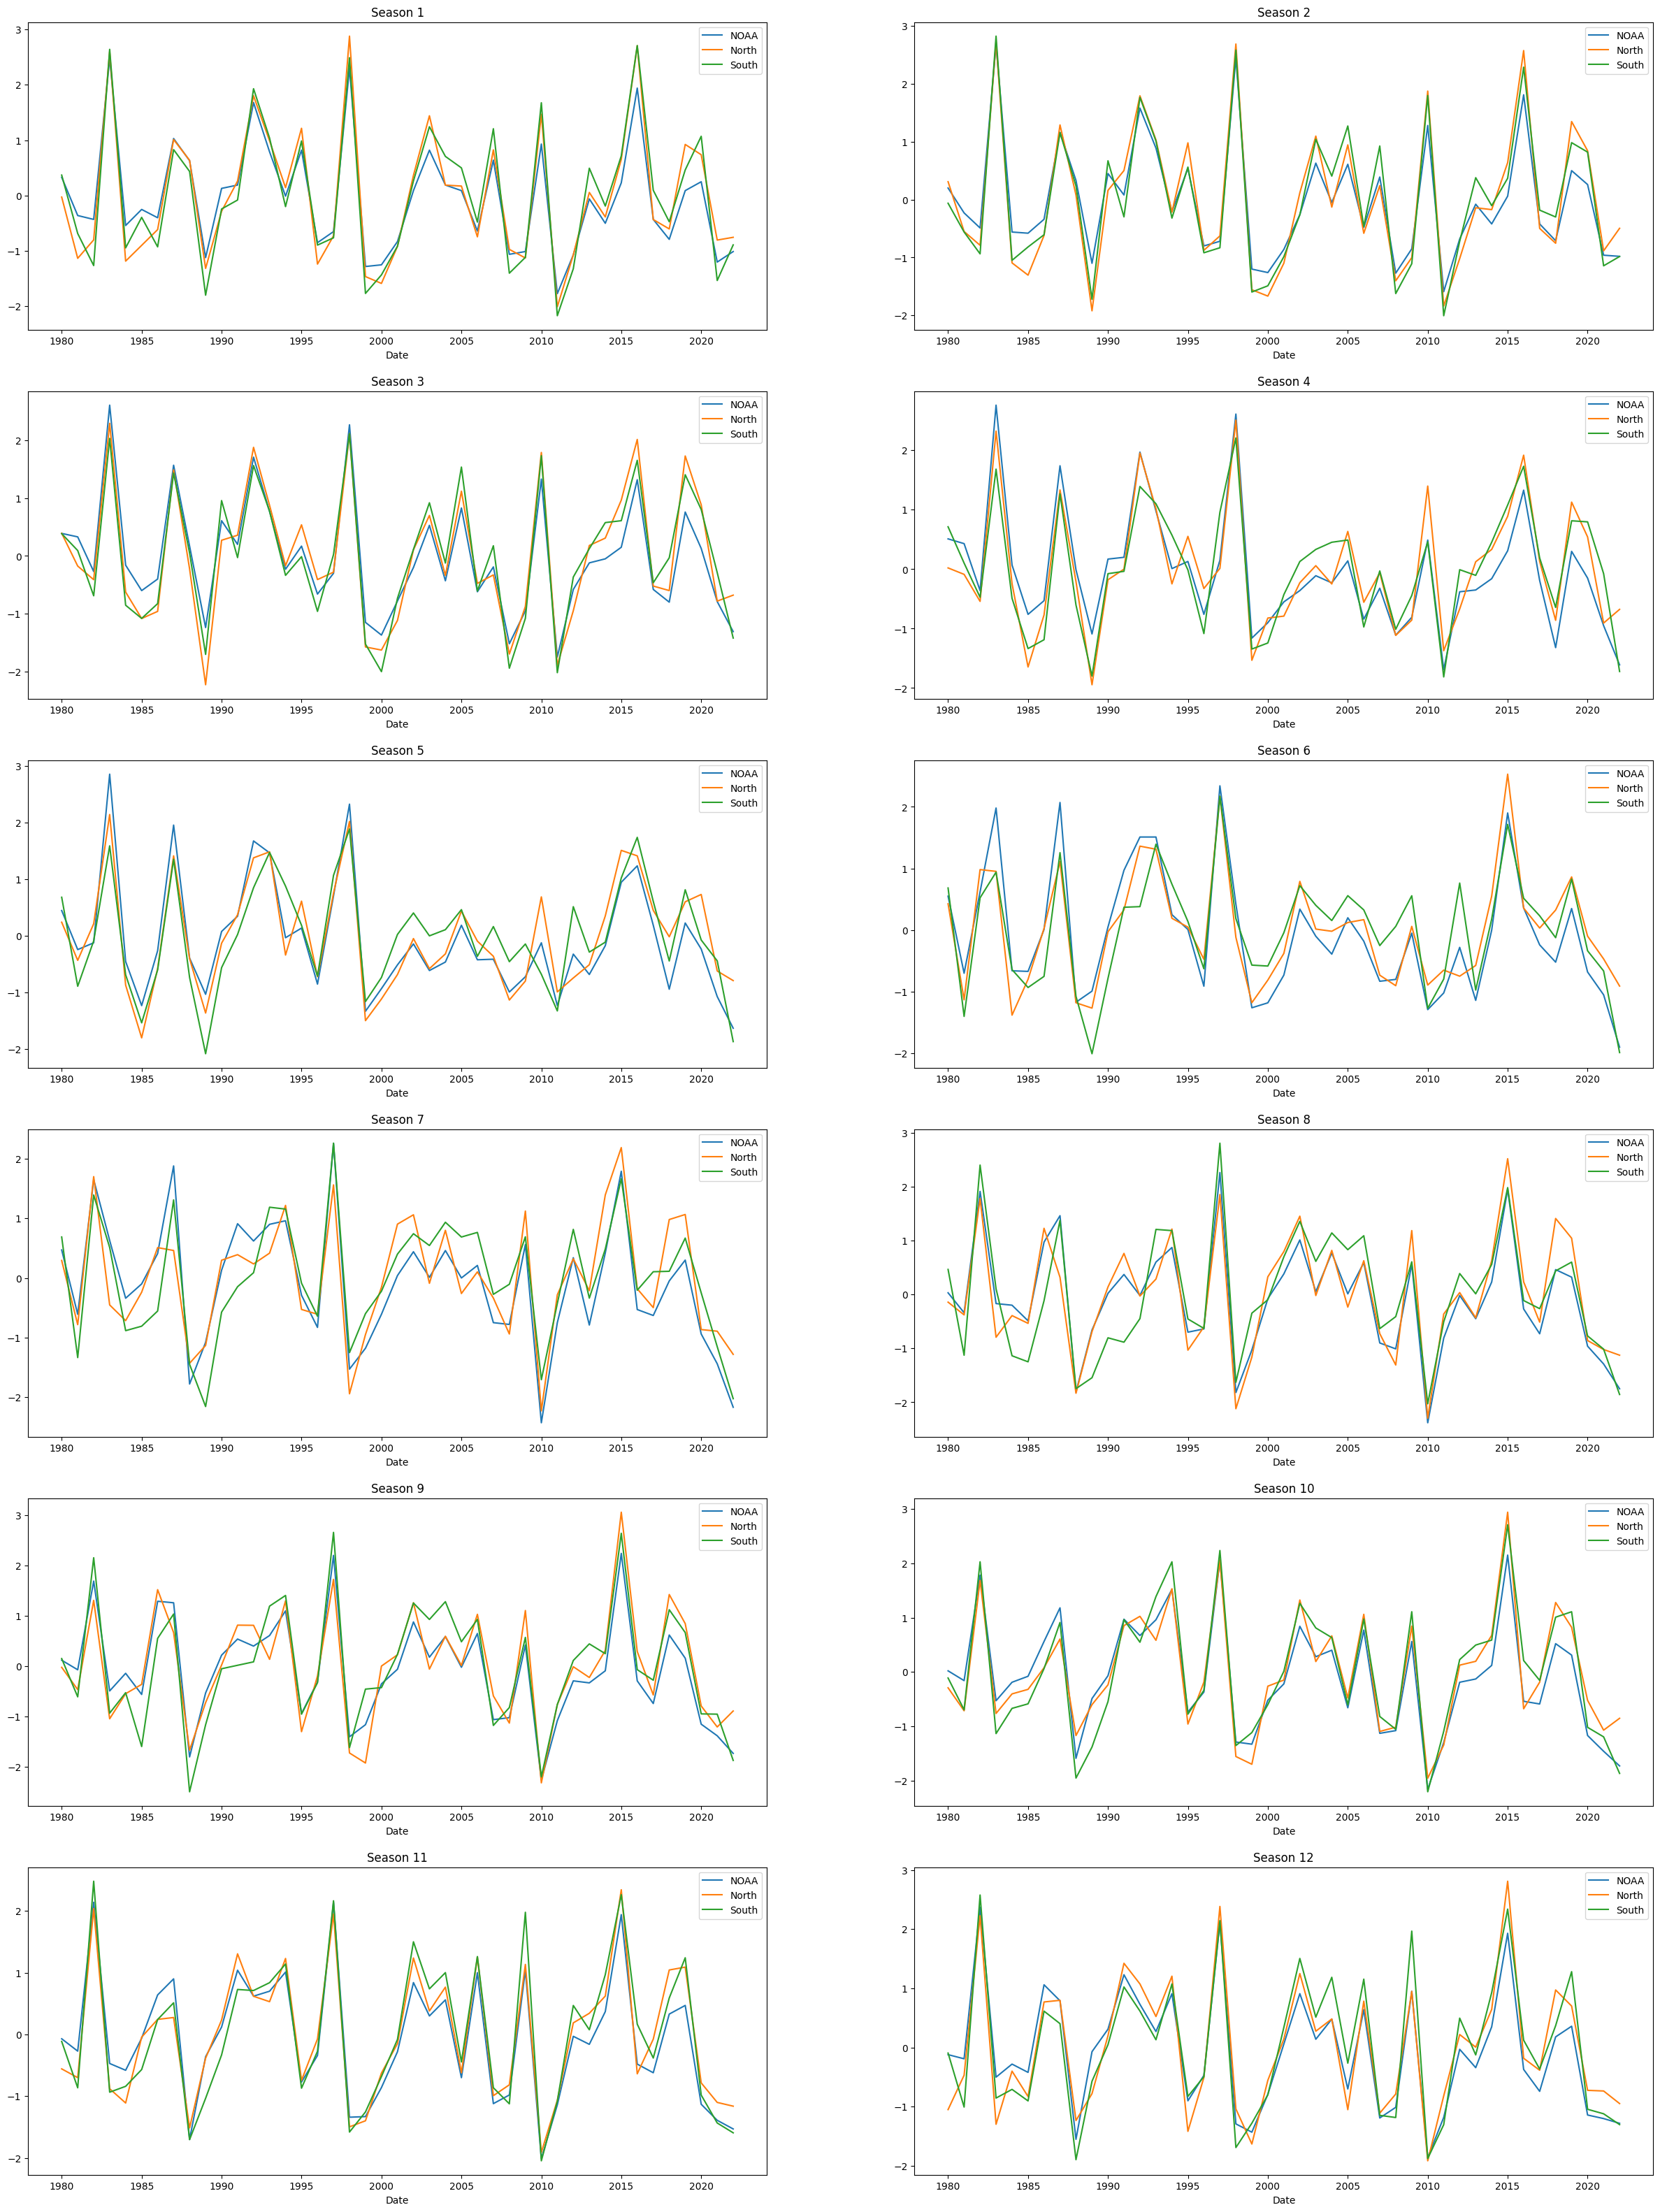

In [36]:
selected = df_mei[(df_mei["Year"]< 2023) & (df_mei["Year"] > 1979)]
selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))
selected.set_index('Date', inplace=True)

fig, axs = plt.subplots(6, 2, figsize=(30,40))
for i in range(1,13):
    axs.flatten()[i-1].plot(selected.index, selected[f"{i}"], label="NOAA")
    #if i>=3 and i not in [5,6]:
    #    pcs[i-1][1] = -pcs[i-1][1]
    axs.flatten()[i-1].plot(selected.index, north_pcs[i-1][1][0], label="North")
    axs.flatten()[i-1].plot(selected.index, south_pcs[i-1][1][0], label="South")
    axs.flatten()[i-1].set_title(f"Season {i}")
    axs.flatten()[i-1].set_xlabel("Date")
    axs.flatten()[i-1].legend()
plt.show()
        

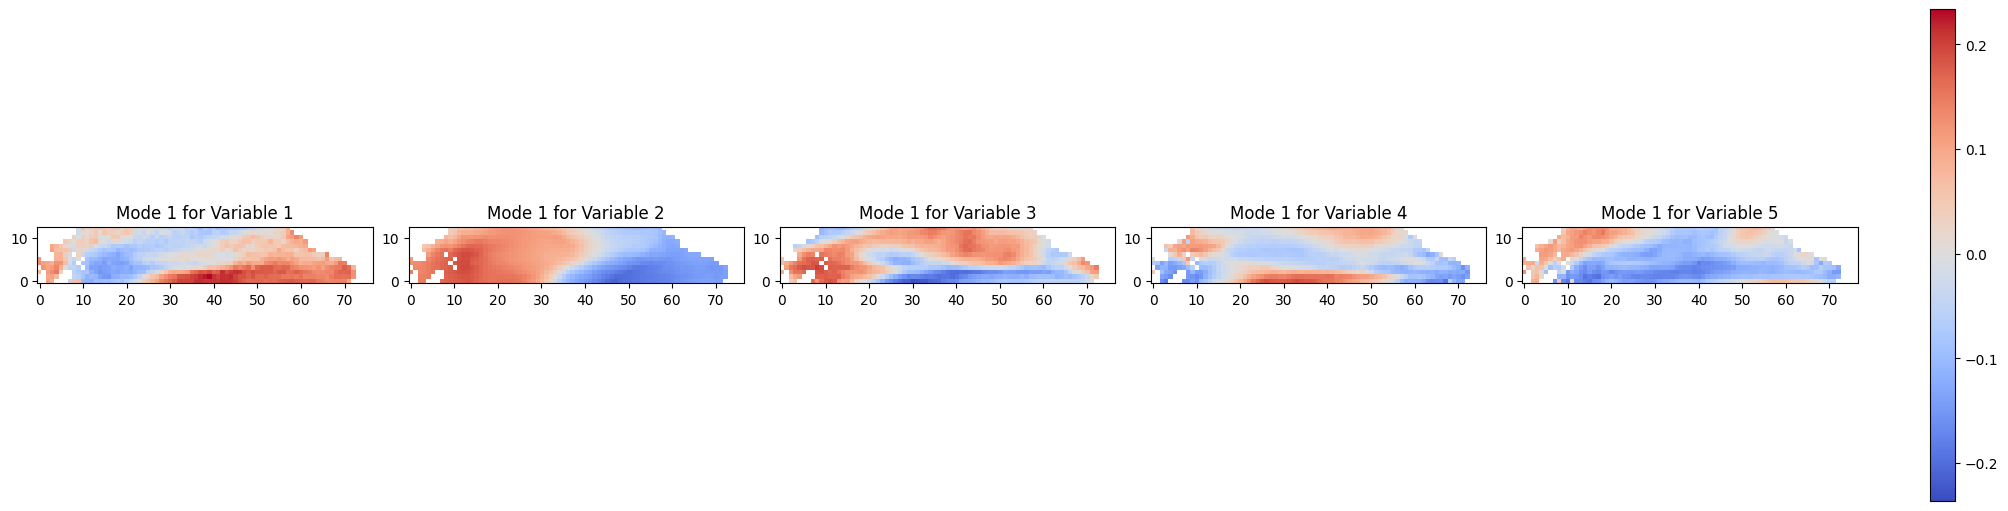

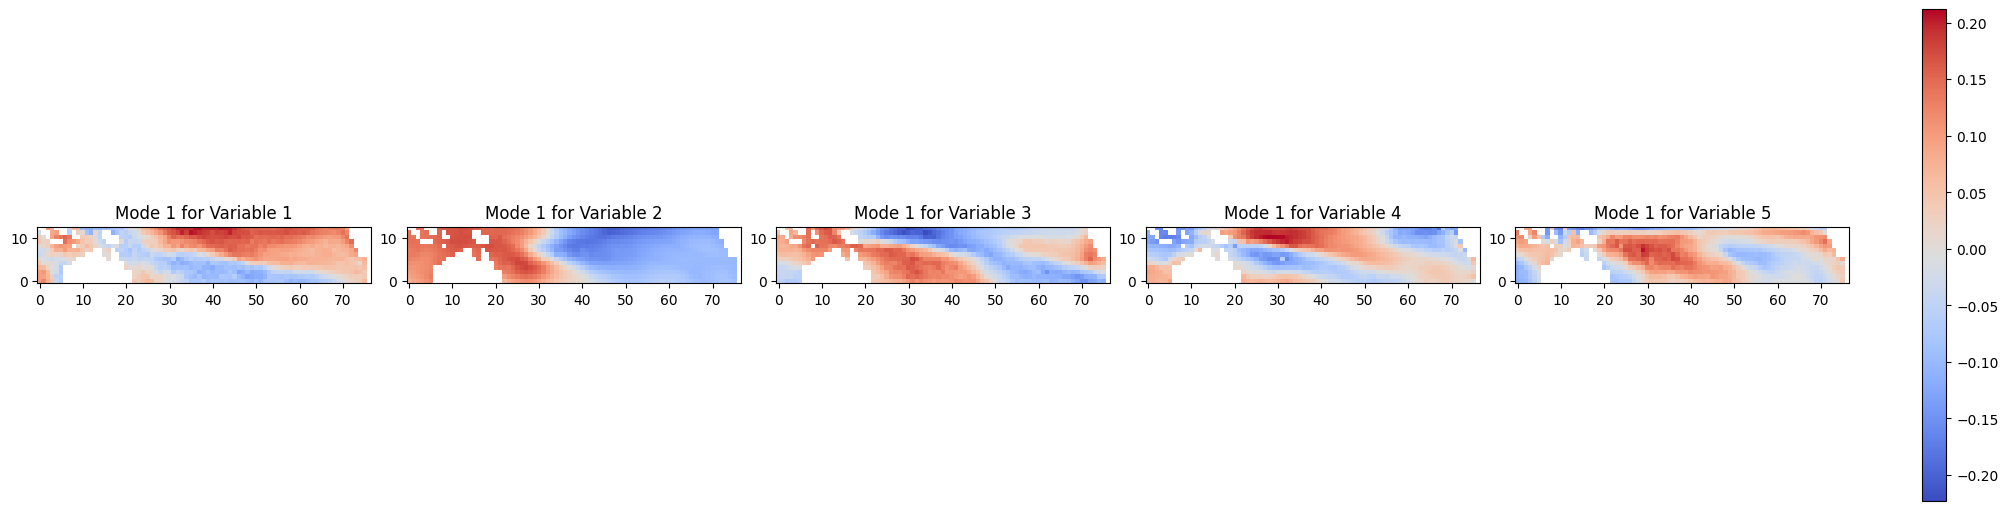

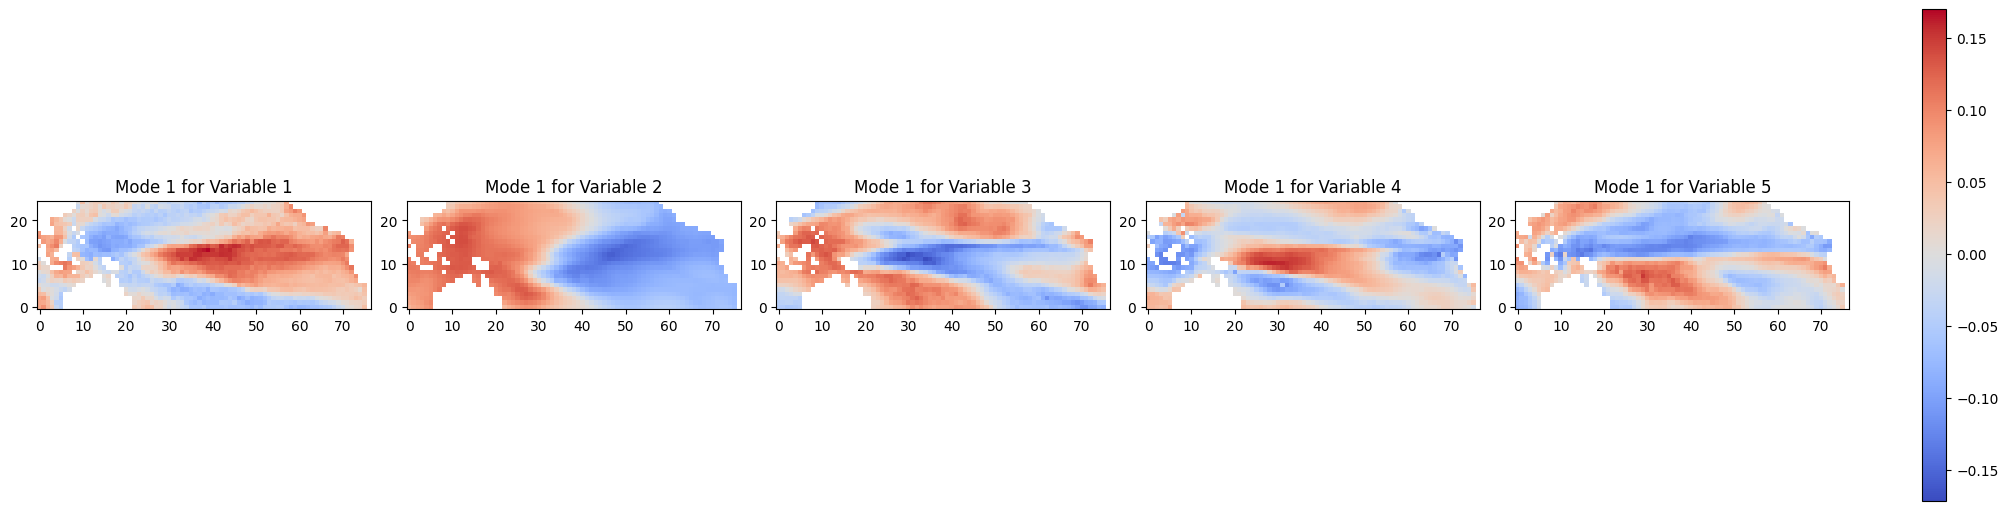

In [19]:
full_modes = map_modes_to_full_grid(north_pcs[0][-2], north_pcs[0][-1], (13,77), n_variables=5)
plot_variable_modes_shared(full_modes, (13,77), 5, 1)
full_modes = map_modes_to_full_grid(south_pcs[0][-2], south_pcs[0][-1], (13,77), n_variables=5)
plot_variable_modes_shared(full_modes, (13,77), 5, 1)
full_modes = map_modes_to_full_grid(pcs[0][-2], pcs[0][-1], (25,77), n_variables=5)
plot_variable_modes_shared(full_modes, (25,77), 5, 1)

Separate the region does not affect the modes. Variability patterns stay equivalent in space. 

## E-W

In [20]:
ds_5means = xr.load_dataset("5means.nc")
col_labels = ["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
df_mei = pd.read_csv("meiv2.data",sep="     |    ", header=None, engine="python", names=col_labels)

In [24]:
east_ds = ds_5means.sel(longitude=slice(195,290))
west_ds = ds_5means.sel(longitude=slice(100,195))

In [45]:
east_pcs = []
for i in range(1,13):
    east_pcs.append(get_first_pc(east_ds, [1980, 2022], biseason=i, nmodes=1))
    print("First eigenvalue for biseason", i, ":", east_pcs[i-1][0], "   Explained Variance:", east_pcs[i-1][2])

for i in range(len(north_pcs)):
    if east_pcs[i][1][0][3] < -1.5 or east_pcs[i][1][0][2] <-1.5 or  east_pcs[i][1][0][2] <-1.2: ##Correct first PC
        east_pcs[i][1][0] = -east_pcs[i][1][0]
        east_pcs[i][3][0] = -east_pcs[i][3][0]

First eigenvalue for biseason 1 : [58.09881615]    Explained Variance: [0.30096671]
First eigenvalue for biseason 2 : [50.23565415]    Explained Variance: [0.26305255]
First eigenvalue for biseason 3 : [41.24534869]    Explained Variance: [0.20983087]
First eigenvalue for biseason 4 : [35.812026]    Explained Variance: [0.19446156]
First eigenvalue for biseason 5 : [33.38192824]    Explained Variance: [0.18102247]
First eigenvalue for biseason 6 : [37.22867562]    Explained Variance: [0.19931243]
First eigenvalue for biseason 7 : [41.33104826]    Explained Variance: [0.2194379]
First eigenvalue for biseason 8 : [51.38199307]    Explained Variance: [0.27340687]
First eigenvalue for biseason 9 : [57.5849369]    Explained Variance: [0.29333844]
First eigenvalue for biseason 10 : [55.46896039]    Explained Variance: [0.28890932]
First eigenvalue for biseason 11 : [51.65455575]    Explained Variance: [0.27164917]
First eigenvalue for biseason 12 : [52.37523865]    Explained Variance: [0.275

In [38]:
west_pcs = []
for i in range(1,13):
    west_pcs.append(get_first_pc(west_ds, [1980, 2022], biseason=i, nmodes=1))
    print("First eigenvalue for biseason", i, ":", west_pcs[i-1][0], "   Explained Variance:", west_pcs[i-1][2])

for i in range(len(west_pcs)):
    if west_pcs[i][1][0][3] < -1.5 or west_pcs[i][1][0][2] <-1.5: ##Correct first PC
        west_pcs[i][1][0] = -west_pcs[i][1][0]
        west_pcs[i][3][0] = -west_pcs[i][3][0]

First eigenvalue for biseason 1 : [65.44432837]    Explained Variance: [0.32389299]
First eigenvalue for biseason 2 : [68.9403919]    Explained Variance: [0.332895]
First eigenvalue for biseason 3 : [64.92929004]    Explained Variance: [0.31988189]
First eigenvalue for biseason 4 : [51.63957509]    Explained Variance: [0.26426394]
First eigenvalue for biseason 5 : [41.60859642]    Explained Variance: [0.21681489]
First eigenvalue for biseason 6 : [35.25182228]    Explained Variance: [0.1775989]
First eigenvalue for biseason 7 : [36.75905185]    Explained Variance: [0.17995736]
First eigenvalue for biseason 8 : [47.25886401]    Explained Variance: [0.22767763]
First eigenvalue for biseason 9 : [48.55936328]    Explained Variance: [0.23477999]
First eigenvalue for biseason 10 : [50.17042523]    Explained Variance: [0.25517274]
First eigenvalue for biseason 11 : [52.4705367]    Explained Variance: [0.26496949]
First eigenvalue for biseason 12 : [53.94459617]    Explained Variance: [0.2774

C:\Users\marti\AppData\Local\Temp\ipykernel_10432\2637017770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))


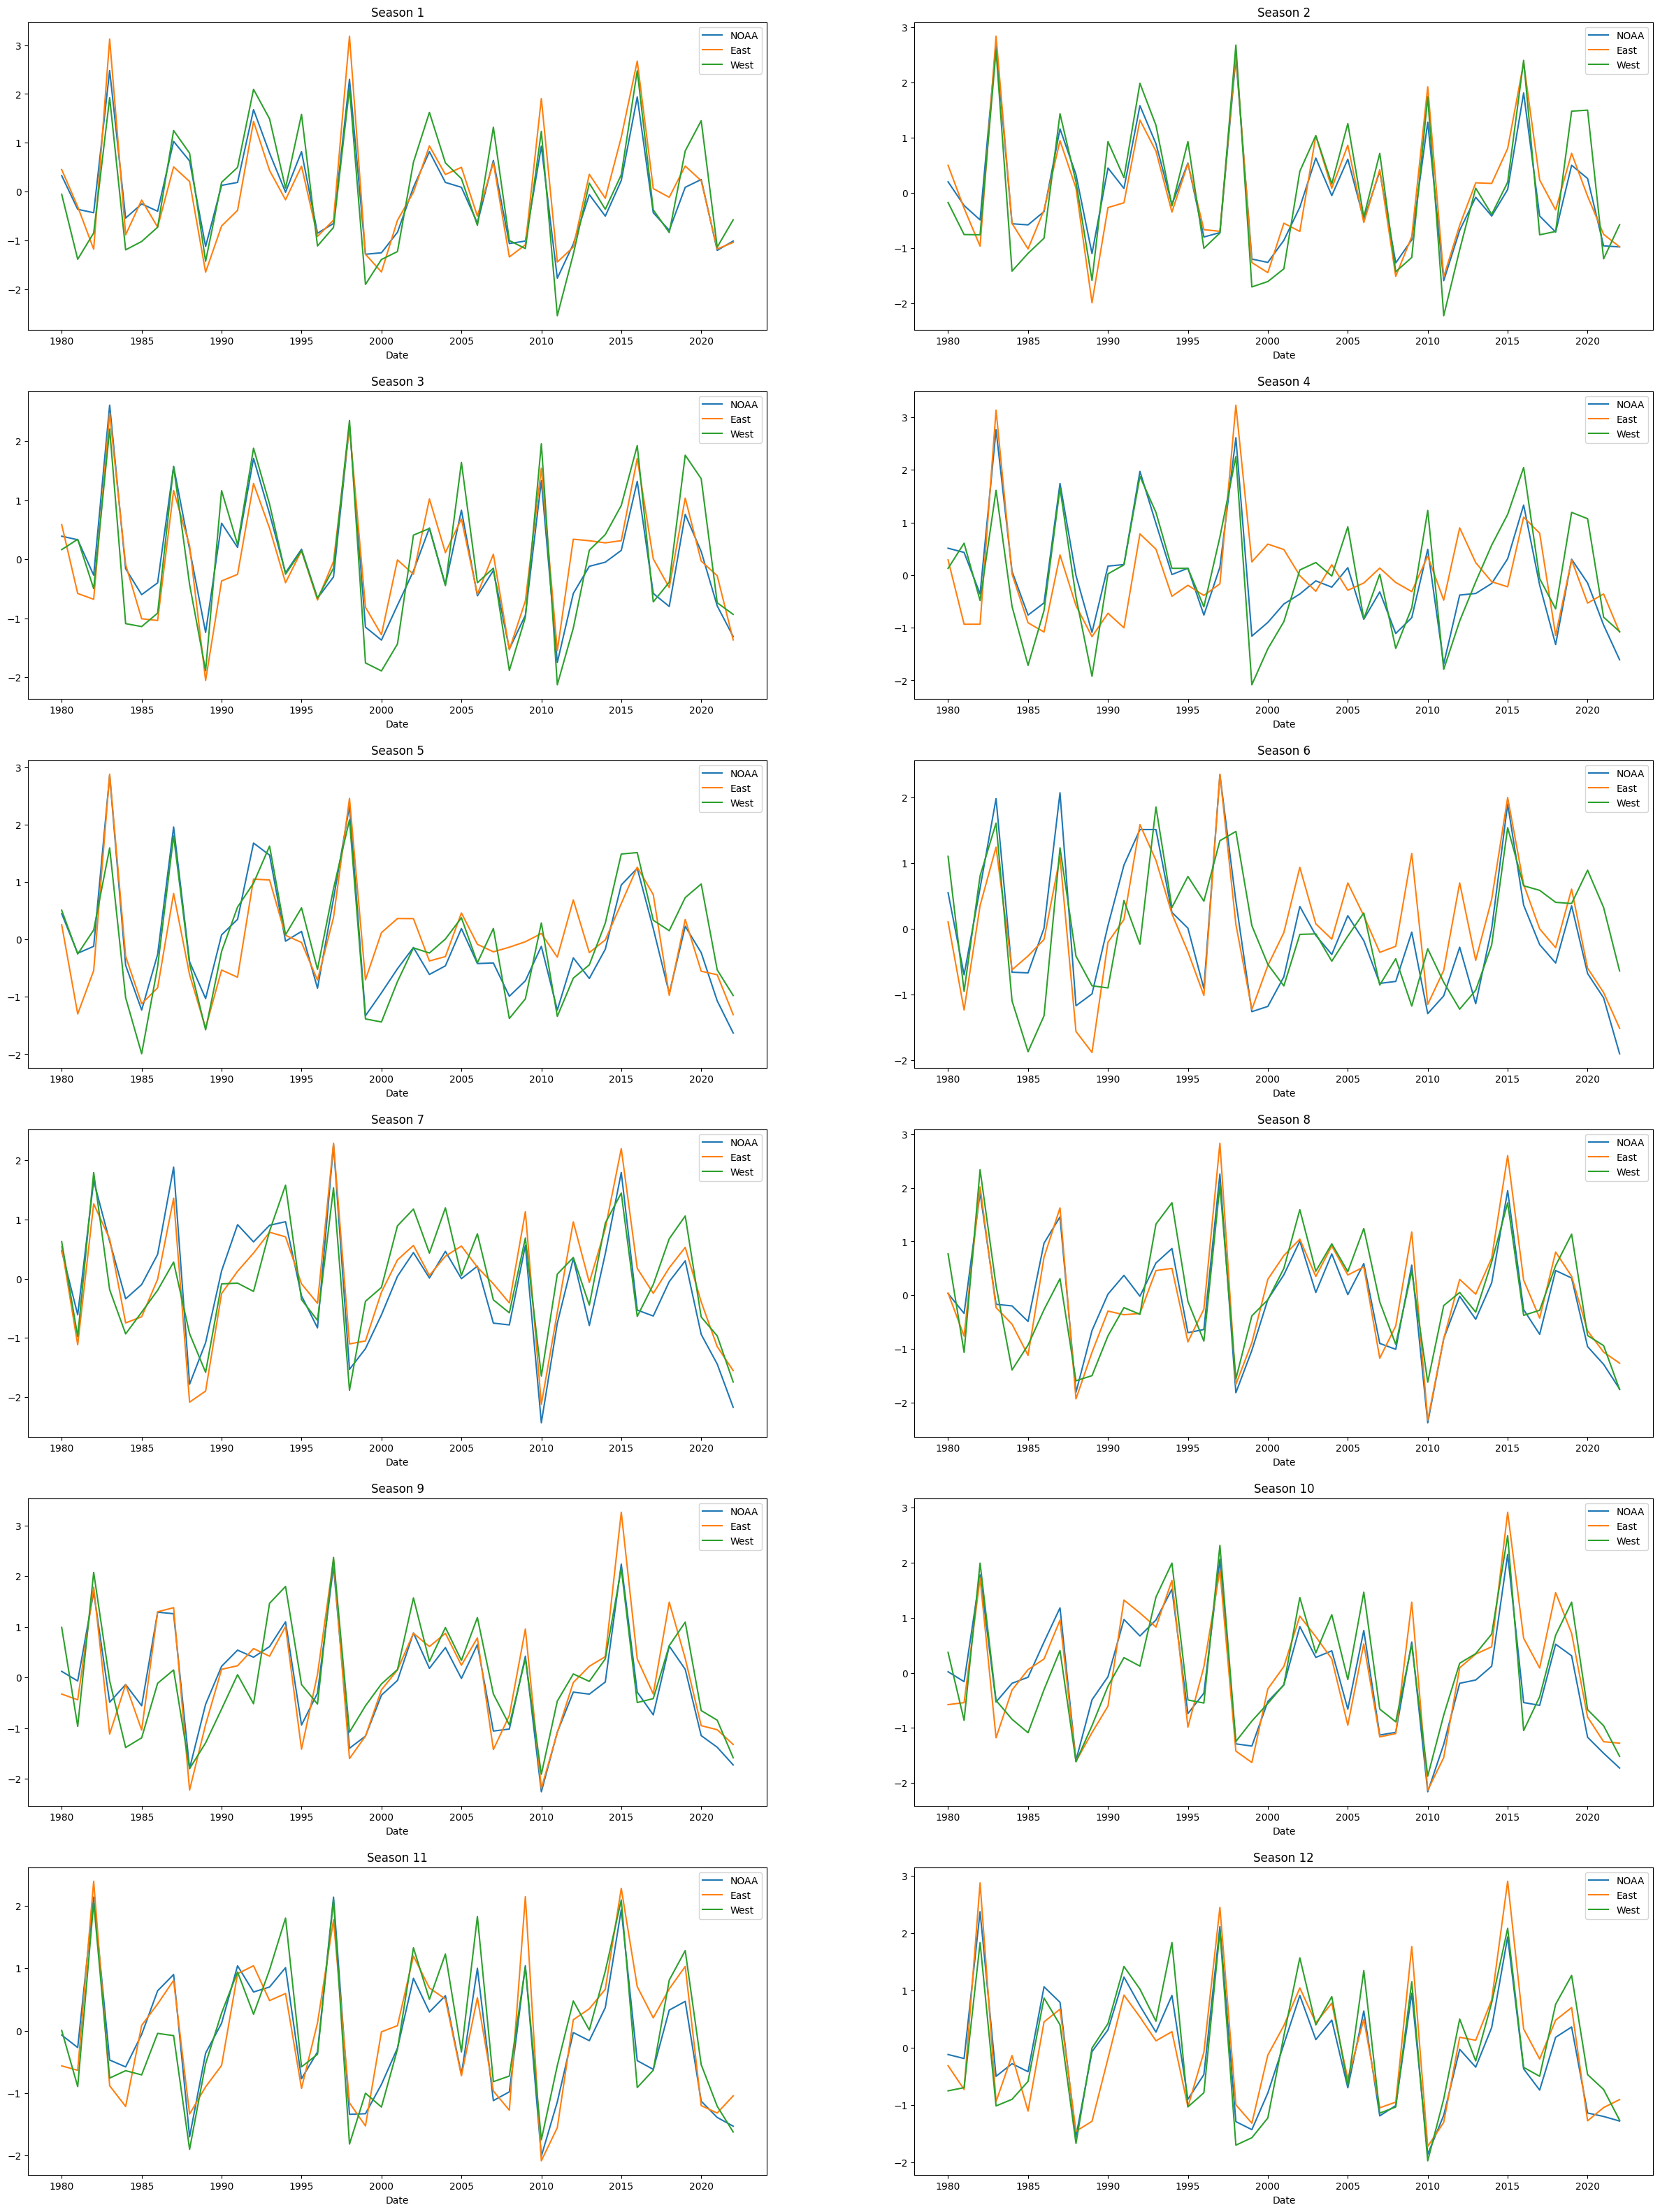

In [46]:
selected = df_mei[(df_mei["Year"]< 2023) & (df_mei["Year"] > 1979)]
selected['Date'] = pd.to_datetime(selected[['Year']].assign(MONTH=1, DAY=1))
selected.set_index('Date', inplace=True)

fig, axs = plt.subplots(6, 2, figsize=(30,40))
for i in range(1,13):
    axs.flatten()[i-1].plot(selected.index, selected[f"{i}"], label="NOAA")
    #if i>=3 and i not in [5,6]:
    #    pcs[i-1][1] = -pcs[i-1][1]
    axs.flatten()[i-1].plot(selected.index, east_pcs[i-1][1][0], label="East")
    axs.flatten()[i-1].plot(selected.index, west_pcs[i-1][1][0], label="West")
    axs.flatten()[i-1].set_title(f"Season {i}")
    axs.flatten()[i-1].set_xlabel("Date")
    axs.flatten()[i-1].legend()
plt.show()
        

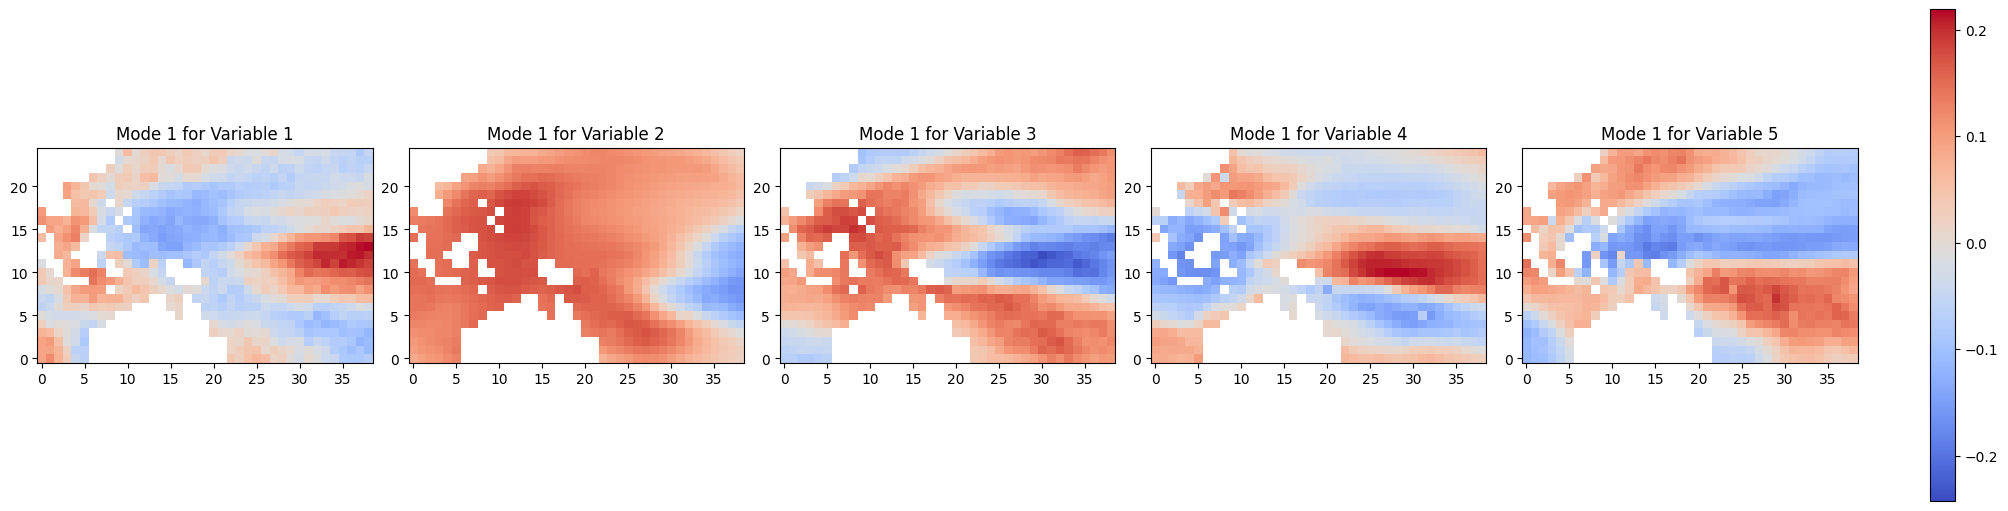

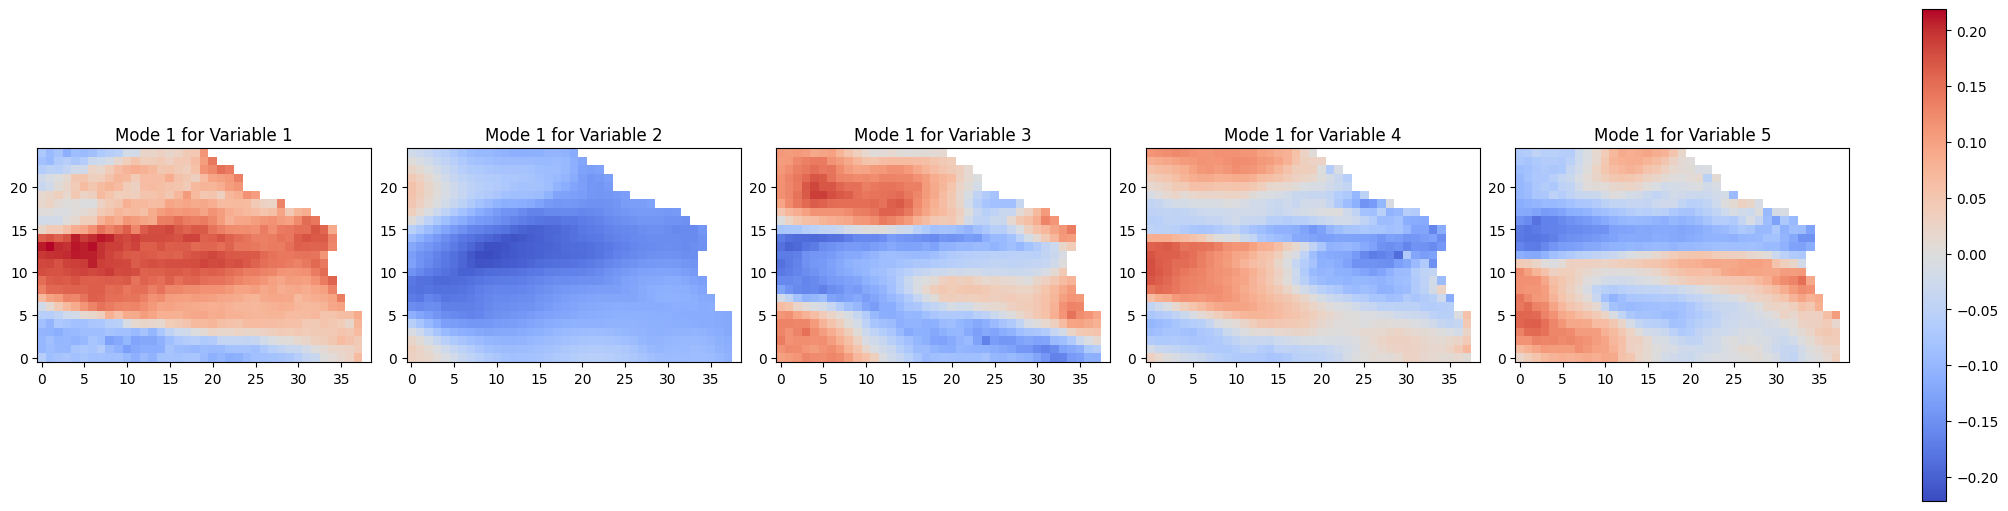

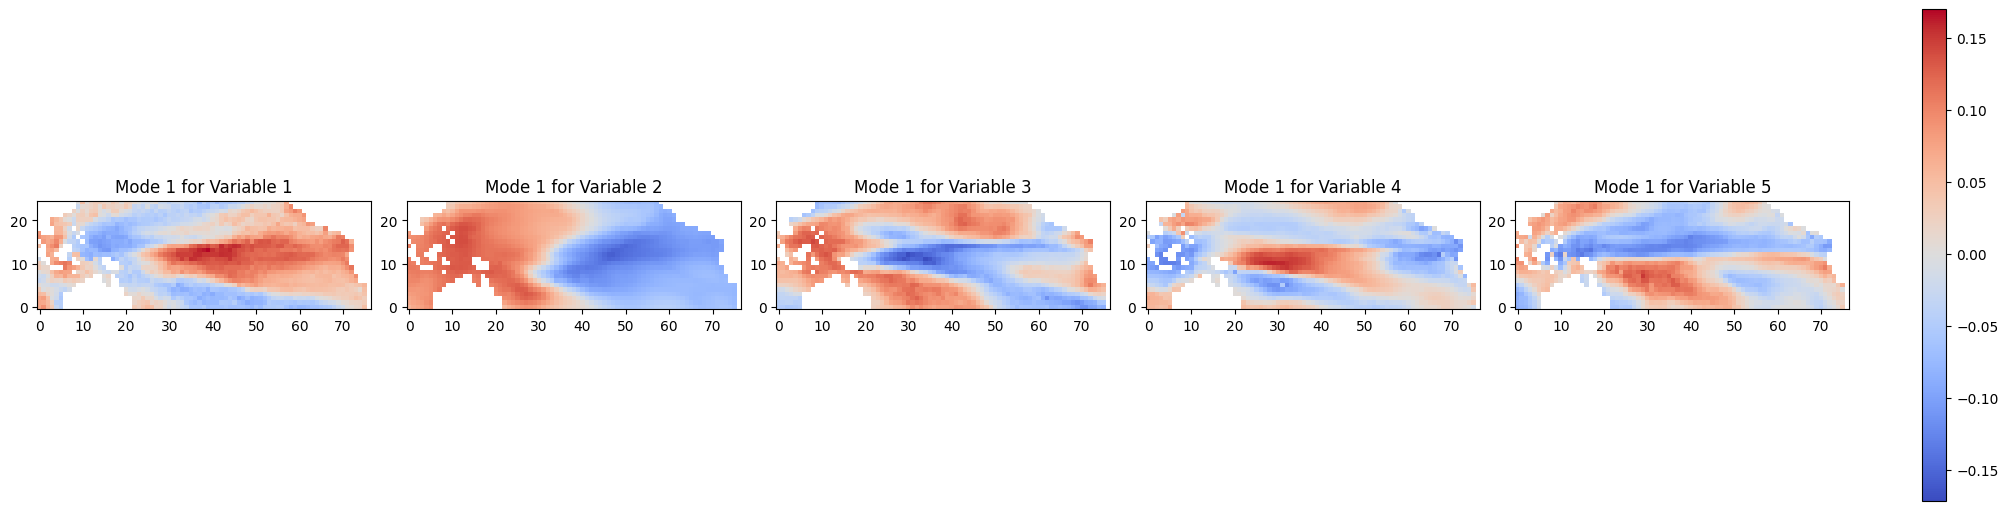

In [47]:
full_modes = map_modes_to_full_grid(west_pcs[0][-2], west_pcs[0][-1], (25,39), n_variables=5)
plot_variable_modes_shared(full_modes, (25,39), 5, 1)

full_modes = map_modes_to_full_grid(east_pcs[0][-2], east_pcs[0][-1], (25,39), n_variables=5)
plot_variable_modes_shared(full_modes, (25,39), 5, 1)

full_modes = map_modes_to_full_grid(pcs[0][-2], pcs[0][-1], (25,77), n_variables=5)
plot_variable_modes_shared(full_modes, (25,77), 5, 1)